In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft,ifft,fftfreq,fftshift

In [2]:
# Now that the simplified version works, I want to build a more general version of this.
# This includes a different number of substates, differentiation between the transitions that model the refractory period and the last transition

def generate_residency_times(transition_rate: int, number_of_substates: int):
    residency_times = []
    rng = np.random.default_rng()
    residency_times = rng.exponential(scale = (1/transition_rate),size = number_of_substates)
    return residency_times

def two_state_process_advanced(number_of_substates: list, transition_rates: list, refractory_periods: list, total_time: float, delta_t: float):
    current_time = 0.0
    target_sequence_length = int(total_time/delta_t)
    initial_state = -1.0
    current_state = initial_state

    state_sequence = []

    transition_rate_substates_A = (number_of_substates[0]-1)/refractory_periods[0]      # in both cases for N substates we have N-1 transitions that approximate the refractory period
    transition_rate_substates_B = (number_of_substates[1]-1)/refractory_periods[1]


    while len(state_sequence) < target_sequence_length:
        # go through chain for state -1
        residency_times = generate_residency_times(transition_rate_substates_A,number_of_substates[0]-1)     #We take number of substates -1 here, because we want to generate the last residdency time independently from the others
        for time in residency_times:
            truncated_time = np.round(time,int(-np.log10(delta_t)))
            number_of_occurence = int(truncated_time/delta_t)
            state_sequence.extend([current_state for _ in range(number_of_occurence)])
            current_state += (1 / number_of_substates[0])
            current_time += truncated_time

        # generate last residency time according to transition rate
        last_residency_time = generate_residency_times(transition_rates[0],number_of_substates=None)
        truncated_time = np.round(last_residency_time,int(-np.log10(delta_t)))
        number_of_occurence = int(truncated_time/delta_t)
        state_sequence.extend([current_state for _ in range(number_of_occurence)])
        current_state += (1 / number_of_substates[0])
        current_time += truncated_time

        # go through chain for state 1
        residency_times = generate_residency_times(transition_rate_substates_B,number_of_substates[1]-1)
        current_state = (1 / number_of_substates[1])

        for time in residency_times:
            truncated_time = np.round(time,int(-np.log10(delta_t)))
            number_of_occurence = int(truncated_time/delta_t)
            state_sequence.extend([current_state for _ in range(number_of_occurence)])
            current_state += (1 / number_of_substates[1])
            current_time += truncated_time

        # generate last residency time according to transition rate
        last_residency_time = generate_residency_times(transition_rates[1],number_of_substates=None)
        truncated_time = np.round(last_residency_time,int(-np.log10(delta_t)))
        number_of_occurence = int(truncated_time/delta_t)
        state_sequence.extend([current_state for _ in range(number_of_occurence)])
        current_state += (1 / number_of_substates[1])
        current_time += truncated_time
        
        # loop back around to initial state -1
        current_state = -1.0

    state_sequence = state_sequence[:target_sequence_length]
    time_sequence = [delta_t*i for i in range(len(state_sequence))]

    return time_sequence,state_sequence



In [3]:
# def function that hides the sequence of substates and identifies them with their "parent state" -1 or 1
def reduce_states(sample_states):
    """
    Takes as input the array that contains the sequence of plotable states and identifies them with super states.

    """
    sample_state_reduced = []
    
    for i,state in enumerate(sample_states):
        if state < 0:
            sample_state_reduced.append(-1)
        else:
            sample_state_reduced.append(1)
    return sample_state_reduced

def two_state_process_reduced(two_state_process_advanced, *args, **kwargs):
    time_sequence,state_sequence = two_state_process_advanced(*args, **kwargs)
    state_sequence = reduce_states(state_sequence)
    return time_sequence,state_sequence

#the following function guarantees that the eigenvector that is chosen is a probability density, i.e. positive and normed to one
def norm_to_probability_density(x: np.array):
    if np.argmax(x) < 0:                   
        x = -x            
    x = 1/(np.sum(x)) * x
    return x

In [4]:
def build_generator_matrix(number_of_substates: list, transition_rates: list, refractory_periods: list):
    """
    Constructs the generator matrix (L) for the two-state renewal process
    with linear chains to model refractory periods.
    
    Args:
        number_of_substates (list): [N, M], the number of substates for state A and B.
        transition_rates (list): The final transition rates out of state A and B.
        refractory_periods (list): The desired mean refractory period for state A and B.

    Returns:
        array: The (N+M)x(N+M) generator matrix L.
    """
    #Define relevant parameters
    N = number_of_substates[0]
    M = number_of_substates[1]

    total_states = N + M

    transition_rates_substates_A = (N-1) / refractory_periods[0]
    transition_rates_substates_B = (M-1) / refractory_periods[1]

    transition_rate_final_A = transition_rates[0]
    transition_rate_final_B = transition_rates[1]

    #Initialize matrix
    L = np.zeros((total_states,total_states))

    for i in range(N-1):
        L[i,i] = (-1 * transition_rates_substates_A)
        L[i+1,i] = transition_rates_substates_A
    
    L[N-1,N-1] = (-1 * transition_rate_final_A)
    L[N,N-1] = transition_rate_final_A

    for i in range(N,N+M-1):
        L[i,i] = (-1 * transition_rates_substates_B)
        L[i+1,i] = transition_rates_substates_B

    L[N+M-1,N+M-1] = (-1 * transition_rate_final_B)
    L[0,N+M-1] = transition_rate_final_B

    return L


def calculate_and_order_eigenspectrum(L: np.array):
    """
    Calculates and plots the eigenvalues of the generator matrix L.

    Args:  generator matrix L
    """
    #calculate lefthand eigenvalues
    eigenvalues_left_raw, eigenvectors_left = np.linalg.eig(L.T)     #since we want the lefthand eigenvectors, we take transpose the matrix here
    #Order eigenvalues by magnitude of real part. The resulting array starts with eigenvalues that have the most negative real part. 
    index_ordering = np.argsort(eigenvalues_left_raw.real)
    eigenvalues_left = eigenvalues_left_raw[index_ordering]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_left)-1):
        if eigenvalues_left[i].real == eigenvalues_left[i+1].real:
            if eigenvalues_left[i].imag > eigenvalues_left[i+1].imag:
                temp = index_ordering[i]
                index_ordering[i] = index_ordering[i+1]
                index_ordering[i+1] = temp
            else: continue
    eigenvalues_left = eigenvalues_left_raw[index_ordering]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_left = []
    for i in index_ordering:
        ordered_eigenvectors_left.append(eigenvectors_left[:,i])

    #Norm stationary left eigenvector to all ones
    for i in range(len(ordered_eigenvectors_left[-1])):
        ordered_eigenvectors_left[-1][i] = np.abs(1/(ordered_eigenvectors_left[-1][i]) * ordered_eigenvectors_left[-1][i])
    

    ################################################

    #calculate righthand eigenvalues
    eigenvalues_right_raw, eigenvectors_right = np.linalg.eig(L)
    
    idx_order = np.argsort(eigenvalues_right_raw.real)
    eigenvalues_right = eigenvalues_right_raw[idx_order]
    #Since there are pairs of eigenvalues with same real part we have to make sure there is a unique ordering. Otherwise this is a source of error. We take the eigenvalues with positive imaginariy part first.
    for i in range(len(eigenvalues_right)-1):
        if eigenvalues_right[i].real == eigenvalues_right[i+1].real:
            if eigenvalues_right[i].imag > eigenvalues_right[i+1].imag:
                temp = idx_order[i]
                idx_order[i] = idx_order[i+1]
                idx_order[i+1] = temp
            else: continue
    eigenvalues_right = eigenvalues_right_raw[idx_order]

    #Order eigenvectors according to the ordering of the eigenvalues
    ordered_eigenvectors_right = []
    for i in idx_order:
        ordered_eigenvectors_right.append(eigenvectors_right[:,i])

    #Norm stationary right eigenvector so that it is a probability distribution
    ordered_eigenvectors_right[-1] = norm_to_probability_density(ordered_eigenvectors_right[-1])

    #Norm the left eigenvectors Q_i to unit variance, as detailed in the paper eq. 9
    for i in range(len(ordered_eigenvectors_left)-1):
        variance = 0
        for j in range(len(ordered_eigenvectors_left[i])):
            variance += np.abs(ordered_eigenvectors_left[i][j])**2 * ordered_eigenvectors_right[-1][j]
        ordered_eigenvectors_left[i] = (1/np.sqrt(variance)) * ordered_eigenvectors_left[i]

    #Enforce biorthogonality 
    for i in range(len(ordered_eigenvectors_right)-1):
        dot_product = ordered_eigenvectors_right[i]@ordered_eigenvectors_left[i]
        ordered_eigenvectors_right[i] = (1/dot_product) * ordered_eigenvectors_right[i]

    return eigenvalues_left,ordered_eigenvectors_left,ordered_eigenvectors_right

def analyzing_and_plotting_eigenspectrum(ordered_eigenvalues, ordered_eigenvectors_left, ordered_eigenvectors_right):
    stationary_eigenvalue = ordered_eigenvalues[-1]

    #the eigenvalue of interest is the eigenvalue with the the largest non-zero real part
    lambda_1 = ordered_eigenvalues[-2]
    mu_1 = lambda_1.real
    omega_1 = lambda_1.imag

    #stationary left eigenvector
    Q_0 = ordered_eigenvectors_left[-1]
    #the following line guarantee that the eigenvalue that is chosen is a probability density, i.e. positive and normed to one

    #the left eigenvector Q_1 that corresponds to the lambda_1
    Q_1 = ordered_eigenvectors_left[-2]
    #Q_1 = norm_to_probability_density(Q_1)
    
    sum_entries_Q_0 = np.sum(Q_0)
    sum_entries_Q_1 = np.sum(Q_1)

    #stationary right eigenvector
    P_0 = ordered_eigenvectors_right[-1]
    #P_0 = norm_to_probability_density(P_0)

    #the right eigenvector P_1 that corresponds to the lambda_1
    P_1 = ordered_eigenvectors_right[-2]
    #P_1 = norm_to_probability_density(Q_1)
    
    sum_entries_P_0 = np.sum(P_0)
    sum_entries_P_1 = np.sum(P_1)


    print("-" * 30)
    print(f"Number of eigenvalues: {len(ordered_eigenvalues)}")
    print(f"Stationary Eigenvalue: {stationary_eigenvalue:.4f}")
    print(f"Oscillatory Eigenvalue (λ₁): {lambda_1:.4f}")
    print(f"Quality factor: {np.abs(omega_1/mu_1)}")
    print("-" * 30)
    print(f"Stationary lefthand Eigenvector: {Q_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary lefthand eigenvector: {sum_entries_Q_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (Q₁): {Q_1}")
    print(" " * 30)
    print(f"Sum of elements of Q₁: {sum_entries_Q_1}")
    print("-" * 30)
    print(f"Stationary righthand Eigenvector: {P_0}")
    print(" " * 30)
    print(f"Sum of elements of stationary righthand eigenvector: {sum_entries_P_0}")
    print(" " * 30)
    print(f"Oscillatory Eigenvector (P₁): {P_1}")
    print(" " * 30)
    print(f"Sum of elements of P₁: {sum_entries_P_1}")


    #Plotting

    # Plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot all eigenvalues
    ax.scatter(ordered_eigenvalues.real, ordered_eigenvalues.imag, c='teal', alpha=0.6, label='Other Eigenvalues')
    ax.scatter(ordered_eigenvalues.real, -ordered_eigenvalues.imag, c='teal', alpha=0.6) # Plot conjugates

    #Highlight eigenvalue with largest non-zero real part
    ax.scatter(lambda_1.real, lambda_1.imag, c='red', alpha=1, s=150, label=f'$\lambda_1$ = {mu_1:.2f} + {omega_1:.2f}i')
    ax.scatter(lambda_1.real, -lambda_1.imag, c='red', alpha=1, s=150) # Plot conjugates

    # Annotate the plot
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.set_xlim(-8.5, 0 + 0.5)
    ax.set_xlabel("Re(λ)", fontsize=14)
    ax.set_ylabel("Im(λ)", fontsize=14)
    ax.set_title("Eigenvalue Spectrum of the Generator Matrix", fontsize=16, weight='bold')
    ax.legend(fontsize=12)
    ax.grid(True)

    plt.show()


In [5]:
#calculate the conditional transition probability from the obtained eigenvetors
def transition_probability(eigenvalues: list, left_eigenvectors: list, right_eigenvectors: list ,initial_state: int,target_state: int,time: float):
        spectral_sum = 0
        for i in range(len(left_eigenvectors)-1):
            spectral_sum += np.exp(eigenvalues[i] * time) * right_eigenvectors[i][target_state] * left_eigenvectors[i][initial_state]
        return right_eigenvectors[-1][target_state] + spectral_sum

In [6]:
#define function that calculates power spectrum for given sequence of time and states by averaging over many realizations of the process
def power_spectrum(process_generator, realizations: int, *args, **kwargs):
    #process generator must return two arrays, one time sequence and one state sequence
    #call process generator once to initialize variables:
    time_sequence,state_sequence = process_generator(*args,**kwargs)
    #state_sequence = reduce_states(state_sequence)                              ####   if this line is uncommented the power spectrum of the superstates is calculated 
    number_sample_points = len(time_sequence)
    dt = time_sequence[1]-time_sequence[0]
    average = np.zeros(number_sample_points)
    #calculate first iteration with initialized variables
    ft_state_sequence = fft(state_sequence)*dt
    average += np.abs(ft_state_sequence)**2

    #calculate ensemble average over remaining realizations
    for i in range(1,realizations):
        time_sequence,state_sequence = process_generator(*args,**kwargs)
        #state_sequence = reduce_states(state_sequence)                          ####   if this line is uncommented the power spectrum of the superstates is calculated
        ft_state_sequence = fft(state_sequence)*dt
        if len(average) == len(ft_state_sequence):
            average += np.abs(ft_state_sequence)**2
        else: 
            print(f'Flag for realisation {i}')
            print(f'Mismatch: {len(average)} is not equal to {len(ft_state_sequence)}')

    #calculate final outputs
    frequency_sequence = fftfreq(number_sample_points,dt)
    power_spectrum_sequence = average/(realizations * (len(time_sequence)*dt))

    return frequency_sequence,power_spectrum_sequence

In [7]:
def phase_reduction(state_sequence: list, Q_1: np.array):
    
    Q_1_sequence = np.zeros(len(state_sequence), dtype=np.complex128)

    
    for i in range(len(state_sequence)):
        #reconstruct the state index from the trajectory value
        ### this assumes that the initial state is -1 and the indexing increases monotonically until state 1 is reached, i.e. -1 has index 0 and 1 has index 19
        x = state_sequence[i]
        if x < 0:
            advancement = np.abs(x - state_sequence[0])
            state_index = int(10*advancement)
        elif x > 0:
            advancement = x
            state_index = int(10*advancement + 9)
        
        #assign calculated Q_1 value
        Q_1_sequence[i] = Q_1[state_index]
        
        complex_argument_Q_1 = np.angle(Q_1_sequence)

    return Q_1_sequence

def phase_reduced_process(time_sequence: list, state_sequence:list, Q_1: np.array):

    complex_argument_Q_1 = phase_reduction(state_sequence, Q_1)

    return time_sequence, complex_argument_Q_1


In [8]:
#the theoretically expected power spectrum of Q_1
def power_spectrum_theoretical_Q_1(eigenvalue: np.complex128, omega: float):
    mu_1 = eigenvalue.real
    omega_1 = eigenvalue.imag
    return (2*np.abs(mu_1)) / (mu_1**2 + (omega - omega_1)**2)

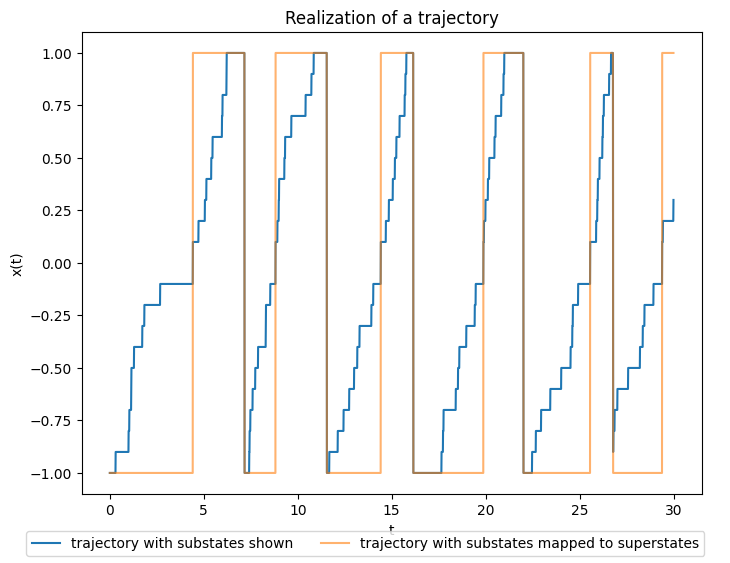

[[-4.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   1. ]
 [ 4.5 -4.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   4.5 -4.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   4.5 -4.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   4.5 -4.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   4.5 -4.5  0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   4.5 -4.5  0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   4.5 -4.5  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   4.5 -4.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   4.5 -1.   0.   0.   0

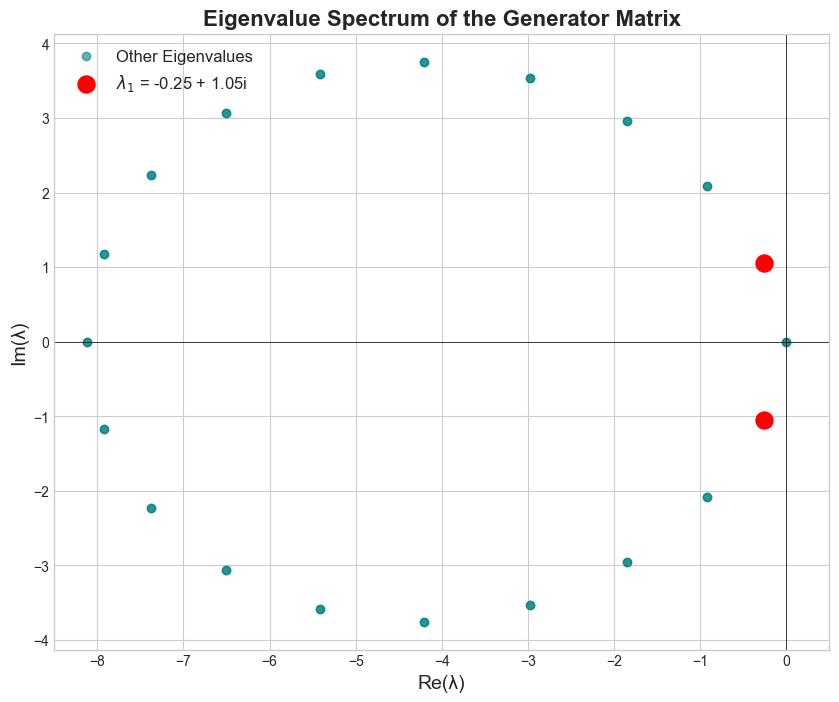

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


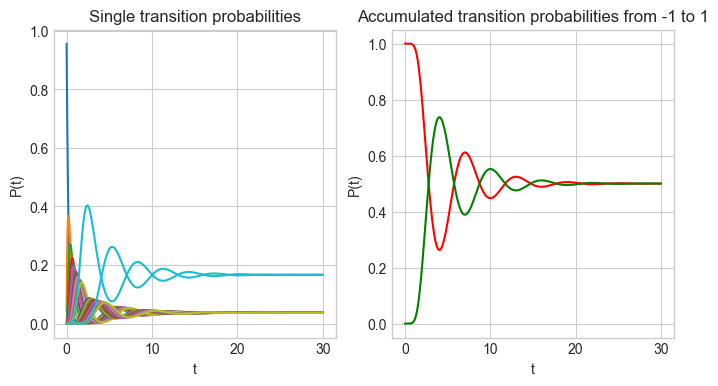

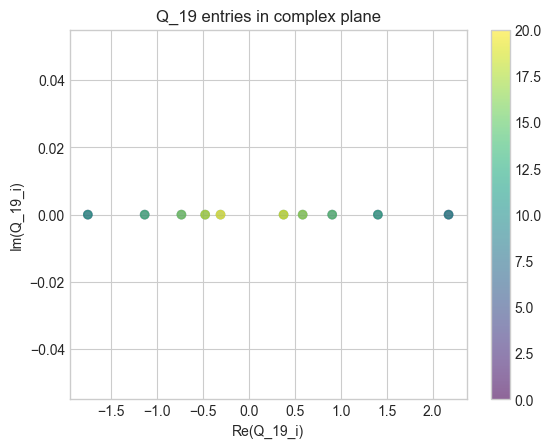

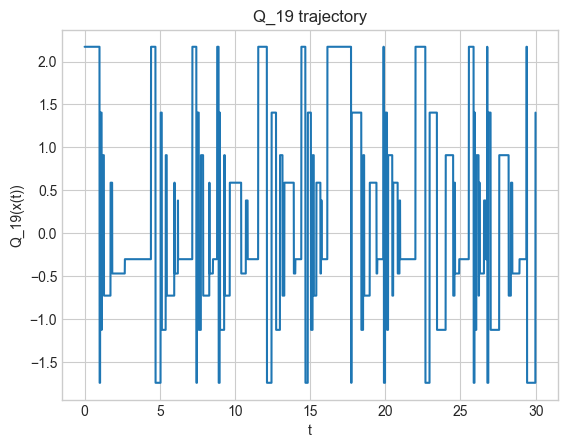

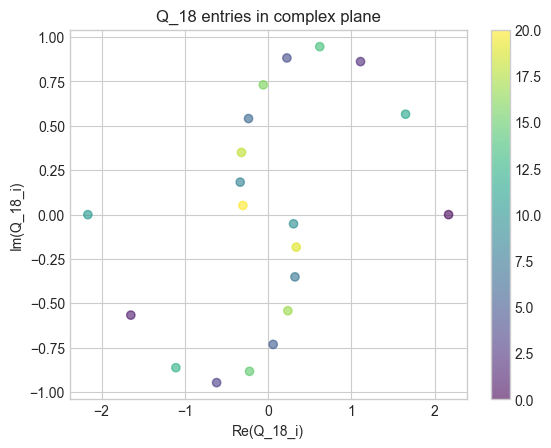

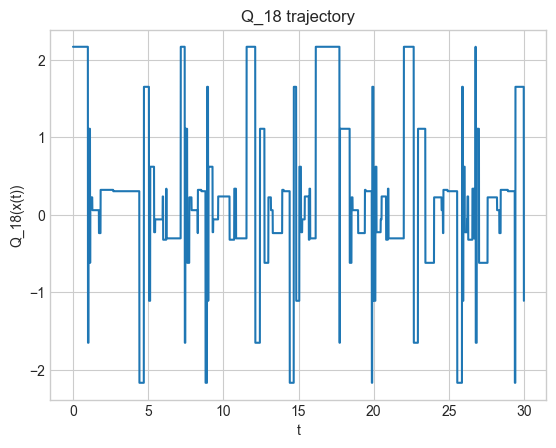

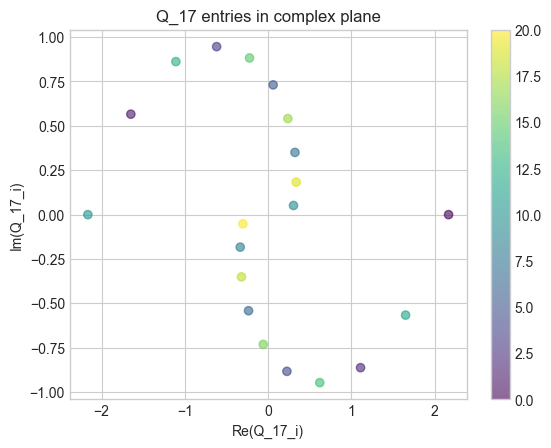

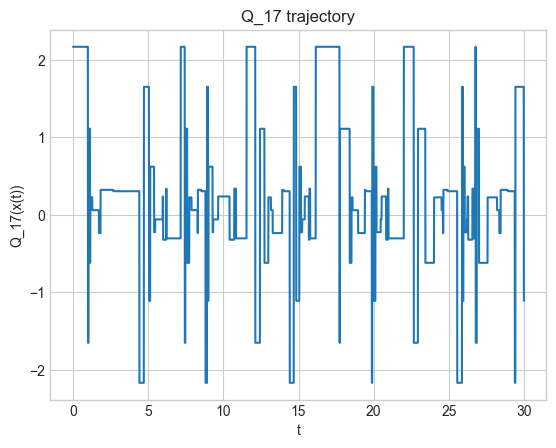

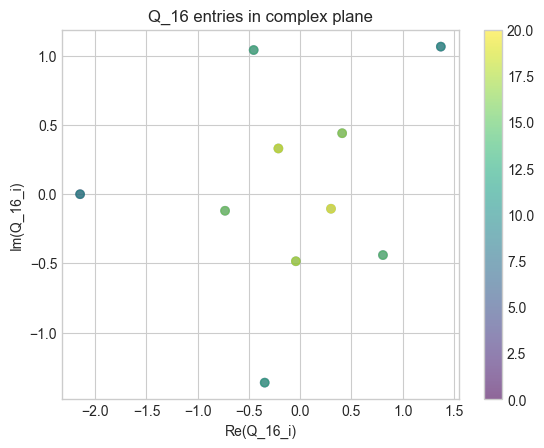

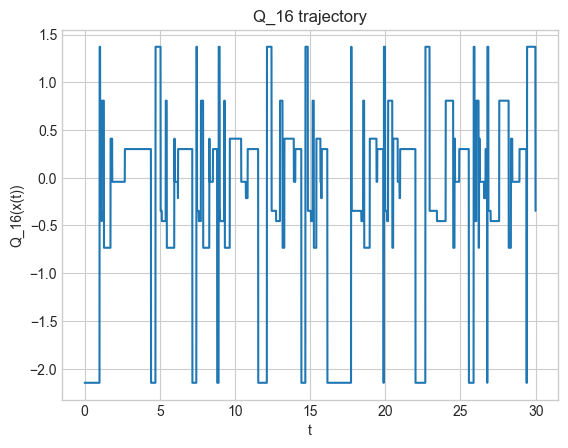

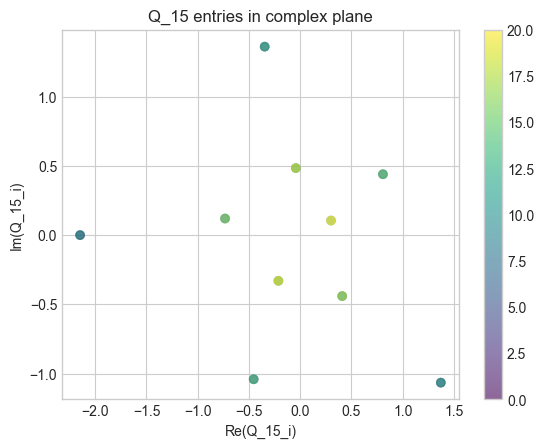

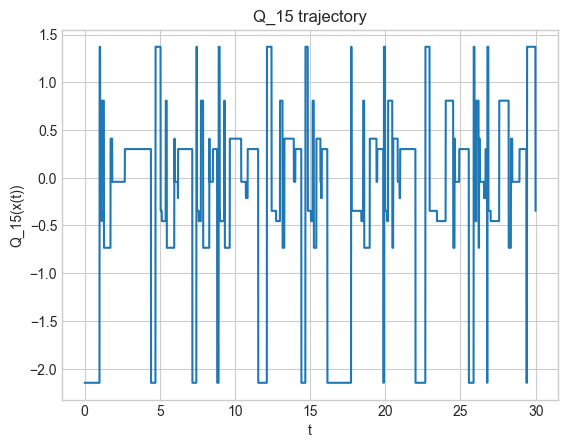

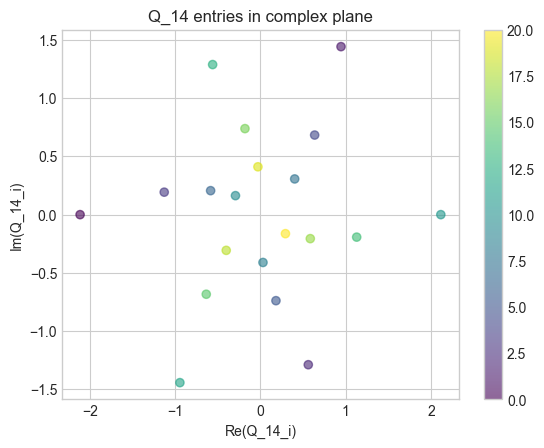

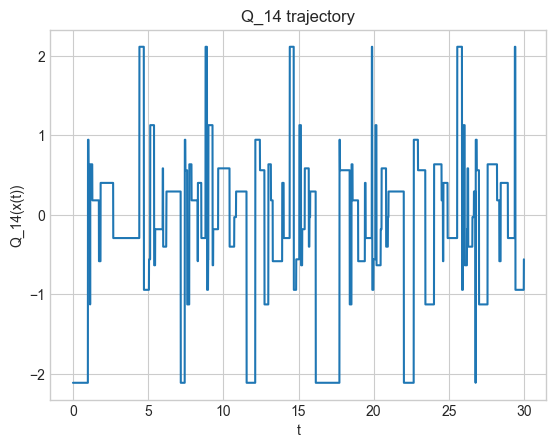

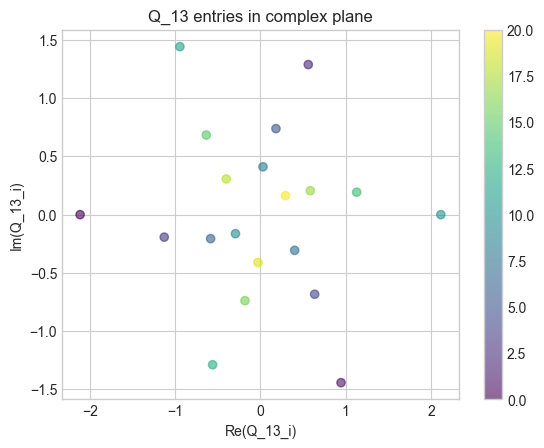

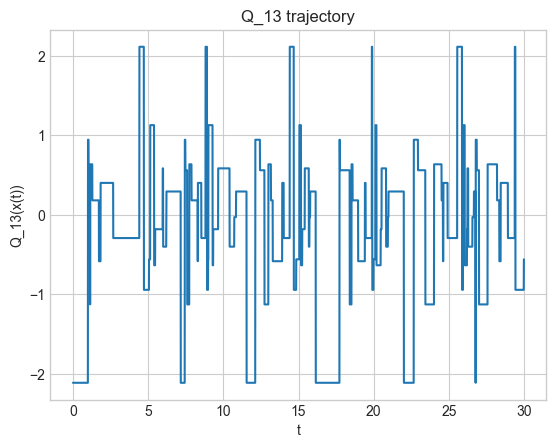

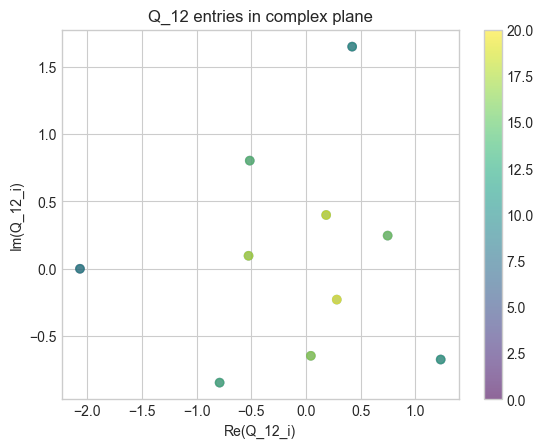

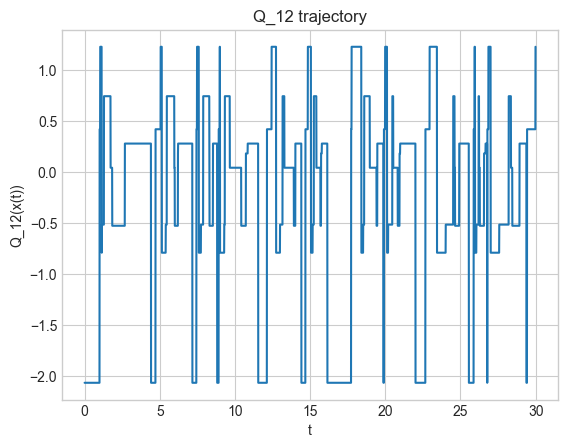

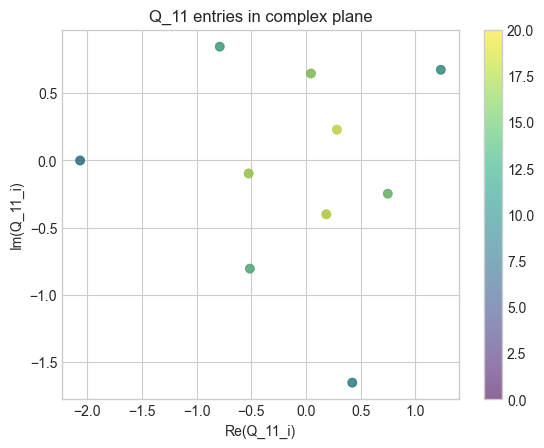

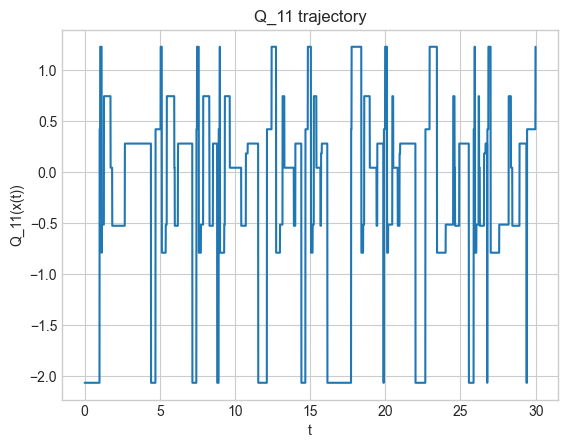

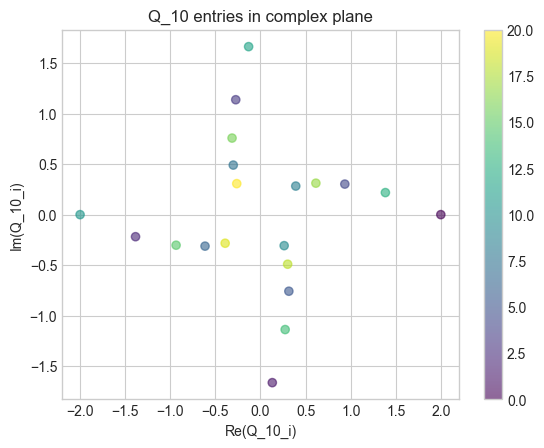

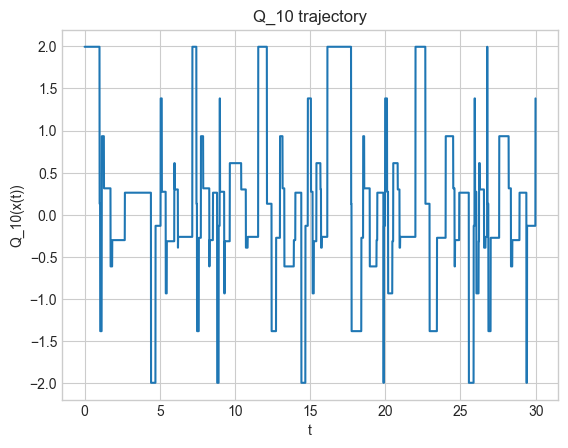

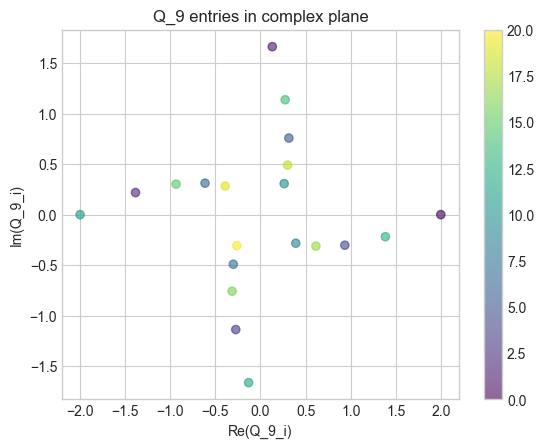

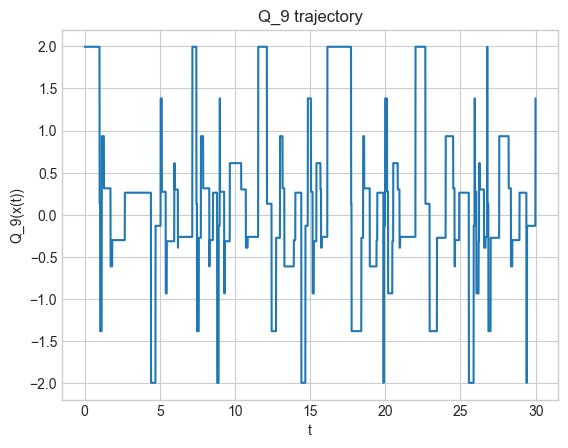

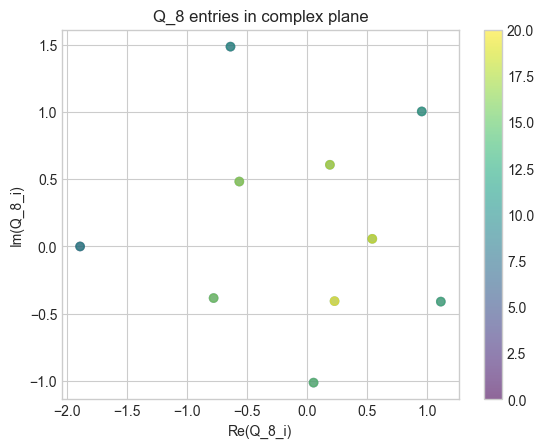

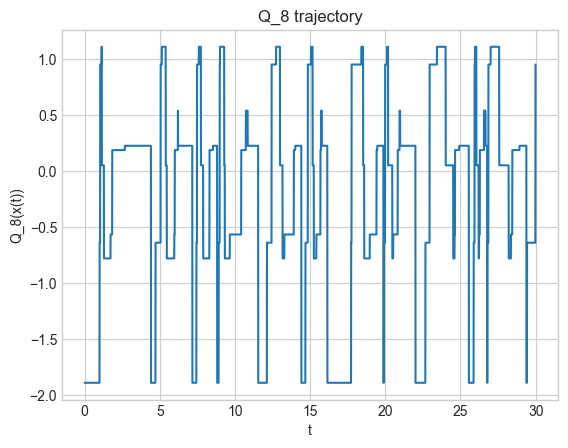

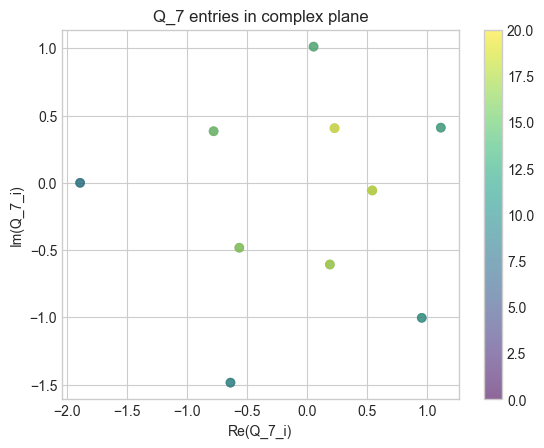

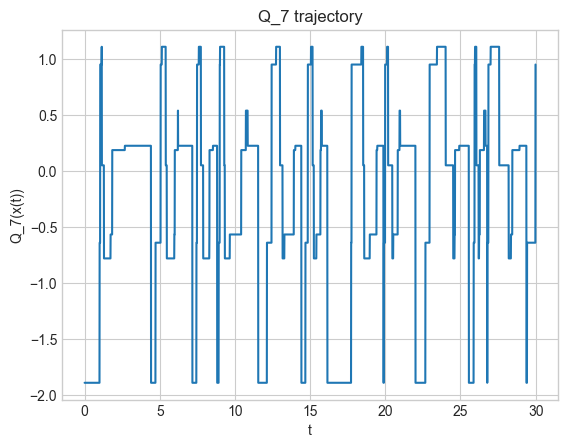

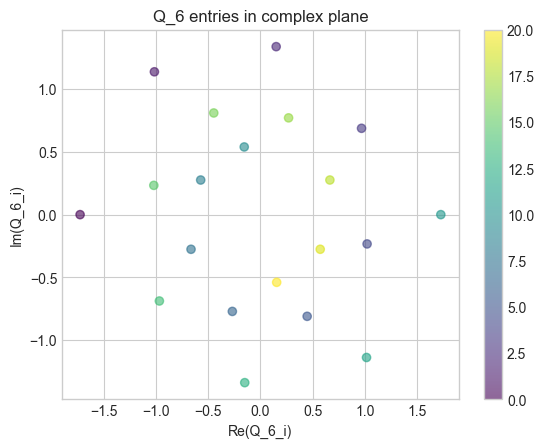

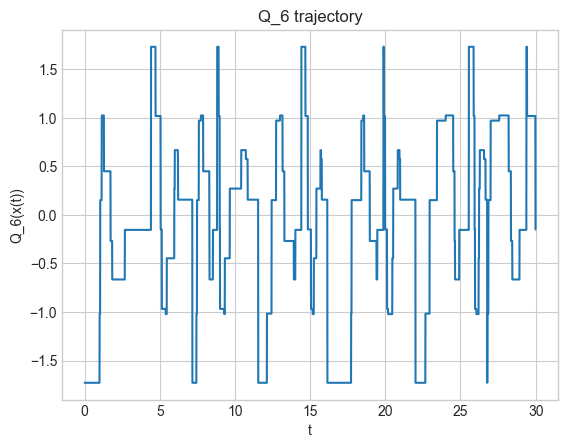

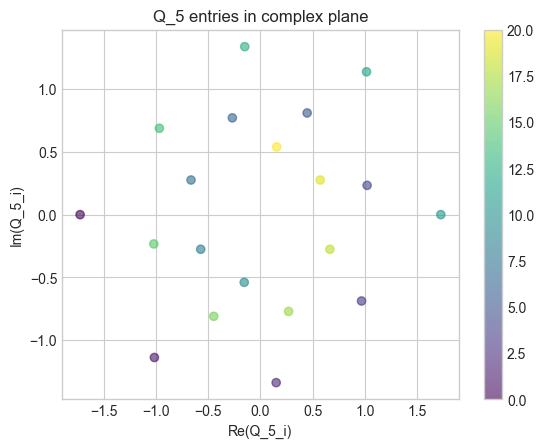

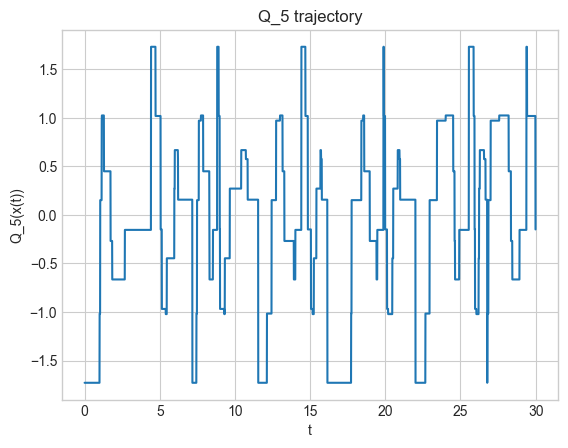

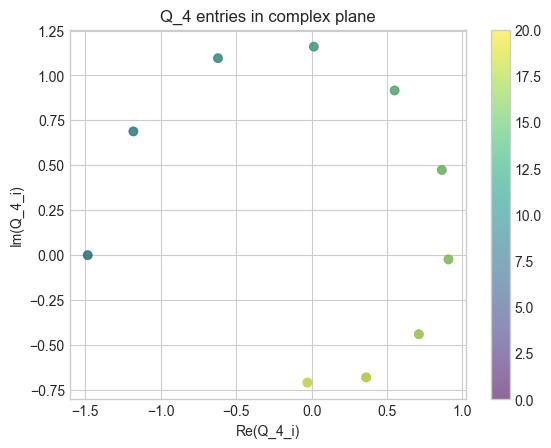

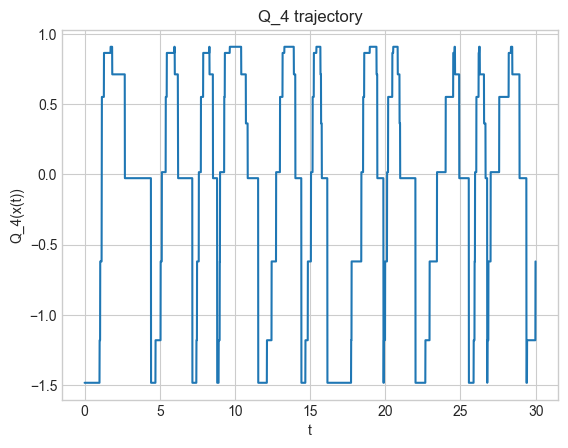

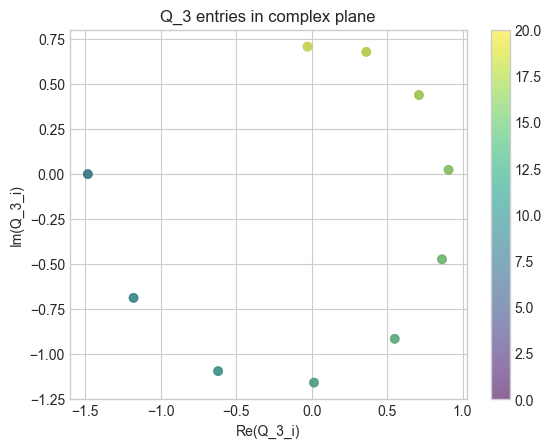

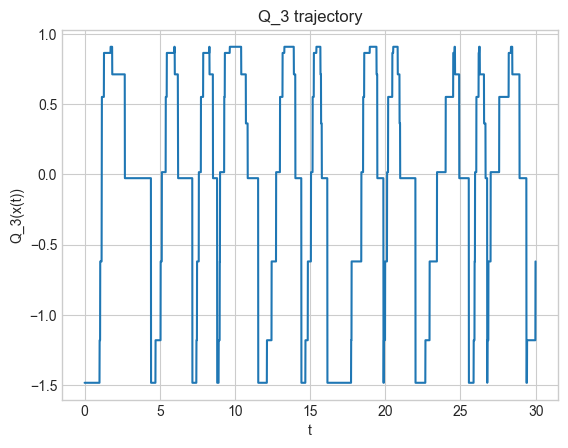

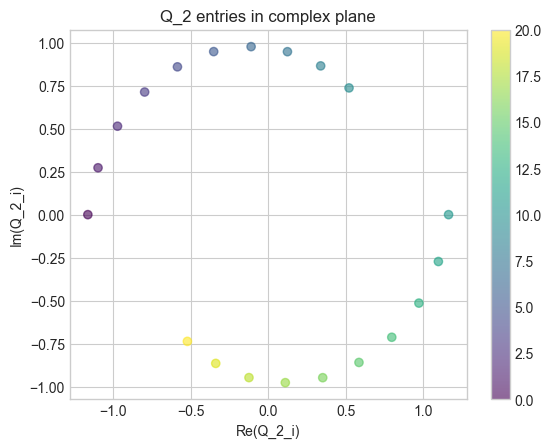

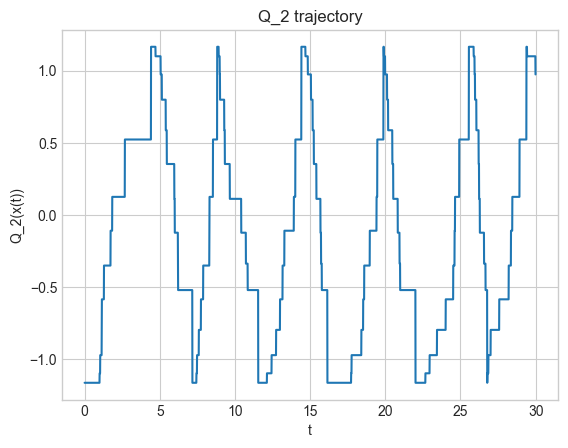

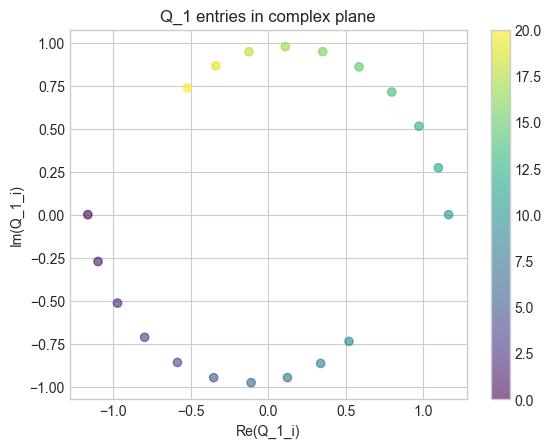

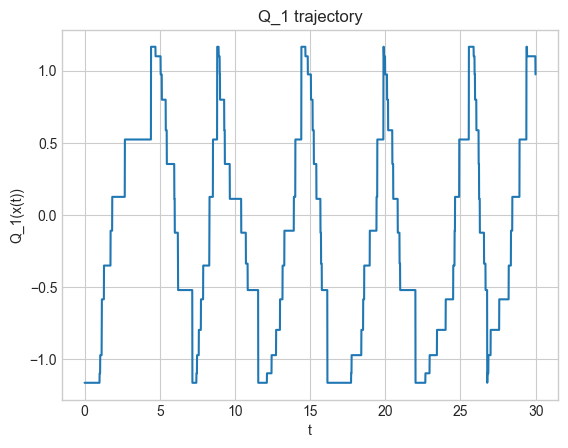

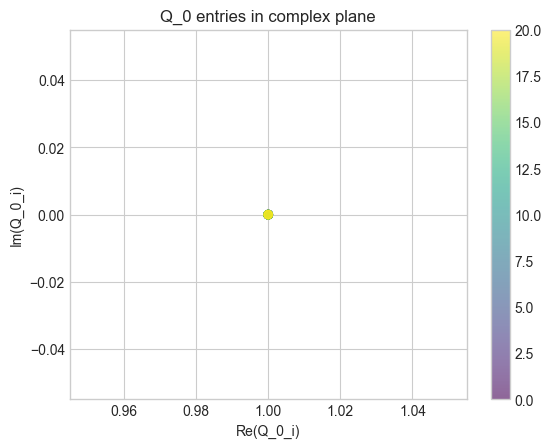

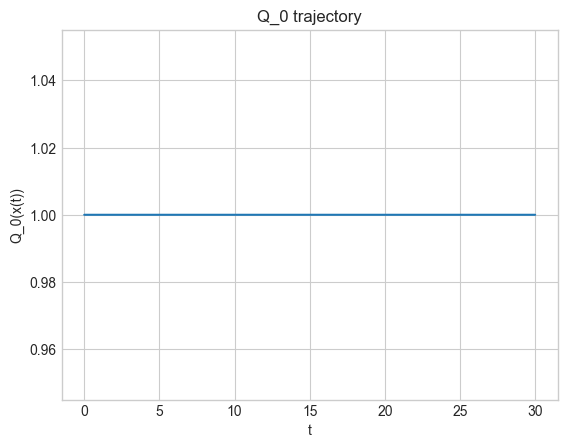

In [9]:
# Parameters
N = 10
M = 10
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 30
delta_t = 0.01

#Plot a trajectory for the given parameters
# Create a figure
fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
generated_time_sequence, generated_state_trajectory = two_state_process_advanced(number_of_substates, transition_rates, refractory_periods, total_time, delta_t)
ax1.set_title('Realization of a trajectory')
ax1.plot(generated_time_sequence, generated_state_trajectory, label='trajectory with substates shown')


#Plot reduced trajectory for the given parameters
reduced_state_trajectory = reduce_states(generated_state_trajectory)
ax1.plot(generated_time_sequence, reduced_state_trajectory, label='trajectory with substates mapped to superstates', alpha = 0.6)
ax1.set_xlabel('t')
ax1.set_ylabel('x(t)')
ax1.grid(False)
fig.legend(loc='lower center', ncols = 2)
plt.show()

#Build generator matrix
L = build_generator_matrix(number_of_substates,transition_rates,refractory_periods)
print(L)


#Calculate eigenspectrum
eigenvals,Q,P = calculate_and_order_eigenspectrum(L)
#Analyze and plot eigenspectrum
analyzing_and_plotting_eigenspectrum(eigenvals,Q,P)

#Plot transition probability over time for a specific pair of states
fig2, (ax1,ax2) = plt.subplots(1,2,figsize = (8,4))
ax1.set_title('Single transition probabilities')
ax1.set_xlabel('t')
ax1.set_ylabel('P(t)')
for i in range(20):
    generated_transition_probability = [transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence]
    ax1.plot(generated_time_sequence,generated_transition_probability)

ax2.set_title('Accumulated transition probabilities from -1 to 1')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')

accum_transition_probability_A = [0 for time in generated_time_sequence]
accum_transition_probability_B = [0 for time in generated_time_sequence]
for i in range(10):
    accum_transition_probability_A = np.add(accum_transition_probability_A,[transition_probability(eigenvals,Q,P,0,i,time+0.01) for time in generated_time_sequence])
    accum_transition_probability_B = np.add(accum_transition_probability_B,[transition_probability(eigenvals,Q,P,0,i+10,time+0.01) for time in generated_time_sequence])
ax2.plot(generated_time_sequence,accum_transition_probability_A,color='red')
ax2.plot(generated_time_sequence,accum_transition_probability_B,color='green')
plt.show()

#Perform transformation to all left hand eigenvectors to infer meaning:
for i in range(len(Q)):
    Q_sequence = phase_reduction(generated_state_trajectory,Q[i])
    colors = np.linspace(0,len(Q),len(Q))
    plt.scatter(Q[i].real, Q[i].imag, c=colors, cmap='viridis', alpha=0.6)
    plt.title(f'Q_{19-i} entries in complex plane')
    plt.xlabel(f'Re(Q_{19-i}_i)')
    plt.ylabel(f'Im(Q_{19-i}_i)')
    plt.colorbar()
    plt.show()
    #complex_argument = np.angle(Q_sequence)
    plt.plot(generated_time_sequence,Q_sequence)
    plt.title(f'Q_{19-i} trajectory')
    plt.xlabel('t')
    plt.ylabel(f'Q_{19-i}(x(t))')
    plt.show()



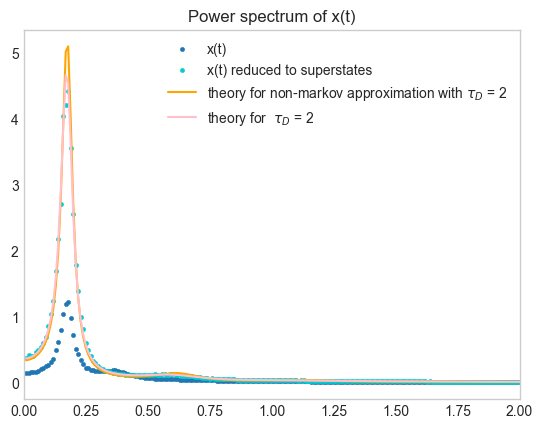

In [10]:
### Testing the power spectrum function for the trajectory and compare it with the non markovian version of the two state porcess
### Qualitatively the function works in this case but the scaling is of. On the point distribution it worked though. So the question remains if the function is off for some unknown reason
### or if our markovian process behaves differently

### ANSWER: The different value assignment of the substates changes the value of the power spectrum. If the substates are identified with its superstate, then the power spectra are the same

# Parameters
N = 50
M = 50
number_of_substates = [N,M]
transition_rates = [1,1]
refractory_periods = [2,2]
total_time = 100
delta_t = 0.01
sim_params = [number_of_substates,number_of_substates,refractory_periods,total_time,delta_t]

# define theoretical power spectrum for non-markovian process that is approximated
def S_approx(f,tau_D):
    return 0.5 * (((1+1)**2 * 1**2)/(1+tau_D)) / (1 + np.cos(2*np.pi*f*tau_D) - 2*np.pi*f*1*np.sin(2*np.pi*f*tau_D) + 2*(np.pi*f*1)**2)

# define theoretical power spectrum for markovian process that we actually have
def S(f: float, refractory_periods:list, final_transition_rates:list, number_of_substates:list):
    N = number_of_substates[0]
    M = number_of_substates[1]
    lambda_A = (N-1)/refractory_periods[0]
    lambda_B = (M-1)/refractory_periods[1]
    lambda_N = final_transition_rates[0]
    lambda_M = final_transition_rates[1]
    FT_rho_A = (lambda_A / (2j*np.pi*f + lambda_A))**(N-1) * (lambda_N/(2j*np.pi*f + lambda_N))
    FT_rho_B = (lambda_B / (2j*np.pi*f + lambda_B))**(M-1) * (lambda_M/(2j*np.pi*f + lambda_M))

    val_super_A = 1
    val_super_B = -1
    mean_residency_time_A = refractory_periods[0] + 1/lambda_N
    mean_residency_time_B = refractory_periods[1] + 1/lambda_M

    S = (2*(val_super_A - val_super_B)**2)/((mean_residency_time_A + mean_residency_time_B)*(2*np.pi*f)**2)  * ((1-FT_rho_A)*(1-FT_rho_B)/(1-FT_rho_A*FT_rho_B)).real
    
    return S

f,psd = power_spectrum(two_state_process_advanced,1000,number_of_substates,transition_rates,refractory_periods,total_time,delta_t)
psd2 = power_spectrum(two_state_process_reduced,1000,two_state_process_advanced, number_of_substates,transition_rates,refractory_periods,total_time,delta_t)[1]
N = len(f)
plt.xlim(0,2)
plt.scatter(f[1:N//2],psd[1:N//2],linewidths=0.4, marker='.', label='x(t)')
plt.scatter(f[1:N//2],psd2[1:N//2],linewidths=0.4, marker='.', color = 'darkturquoise', label = 'x(t) reduced to superstates')
plt.plot(f[1:N//2],[S_approx(x,2) for x in f[1:N//2]], label=f'theory for non-markov approximation with $\\tau_D$ = {2}', color = 'orange')
plt.plot(f[1:N//2],[S(x,refractory_periods, transition_rates, number_of_substates) for x in f[1:N//2]], label=f'theory for  $\\tau_D$ = {2}', color = 'pink')
plt.title('Power spectrum of x(t)')
plt.legend()
plt.grid(False)
plt.show()

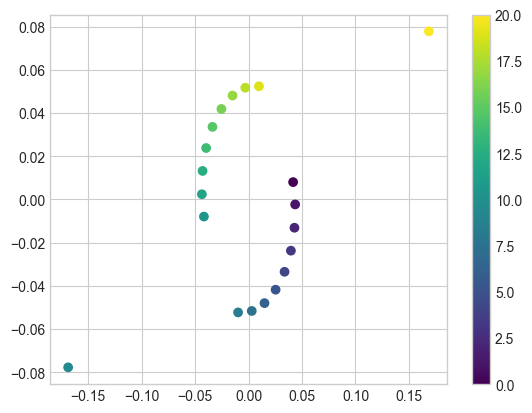

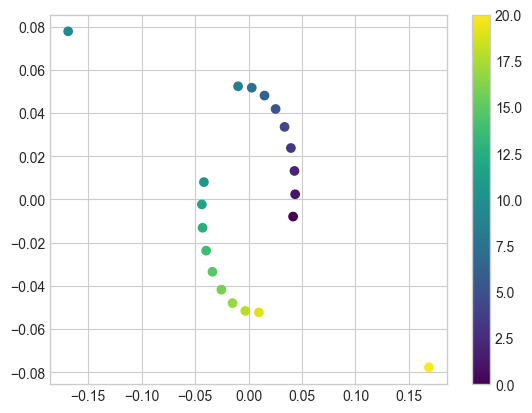

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


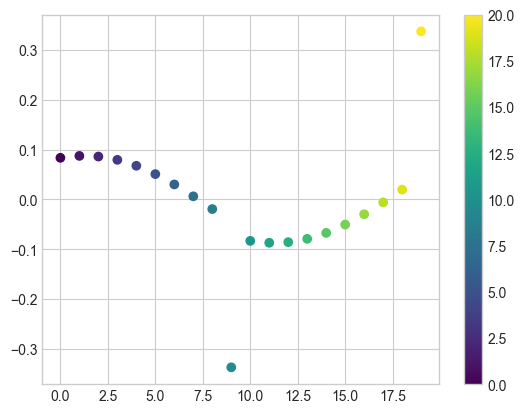

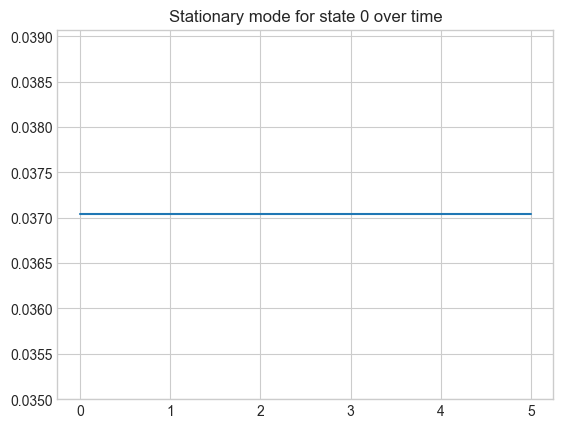

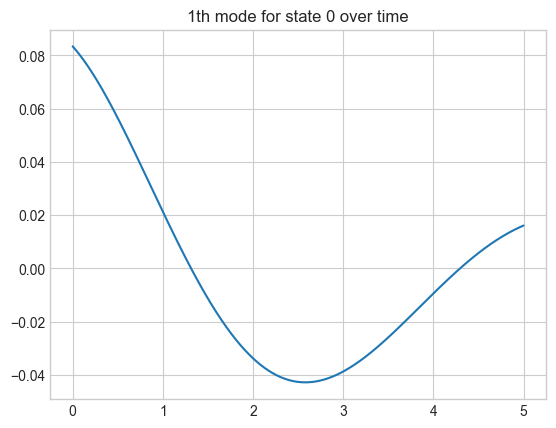

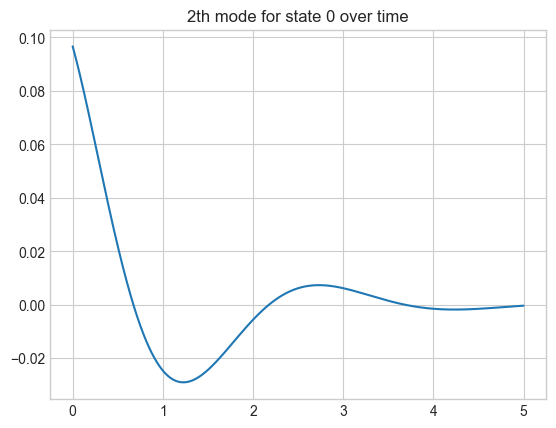

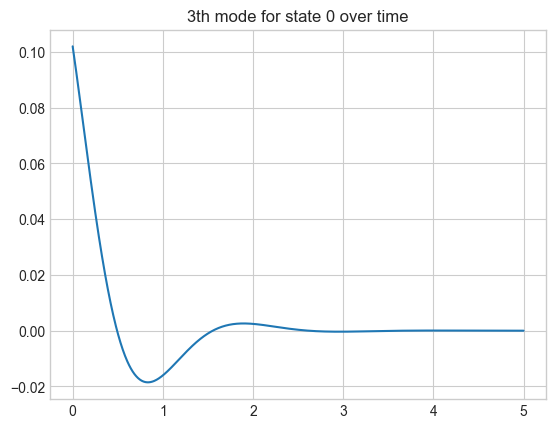

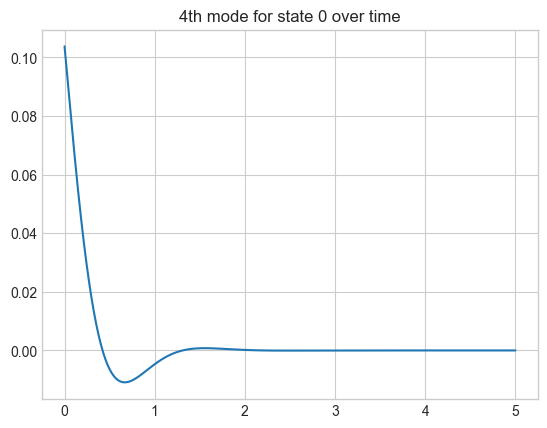

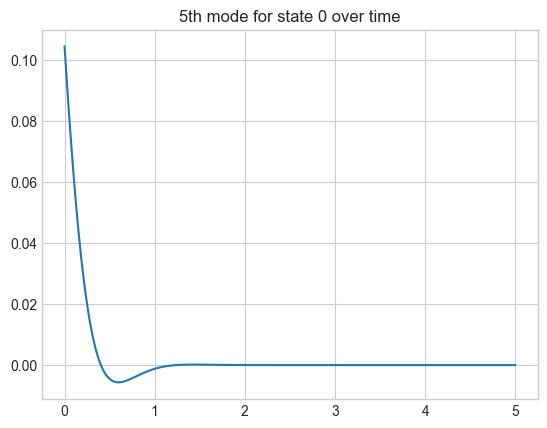

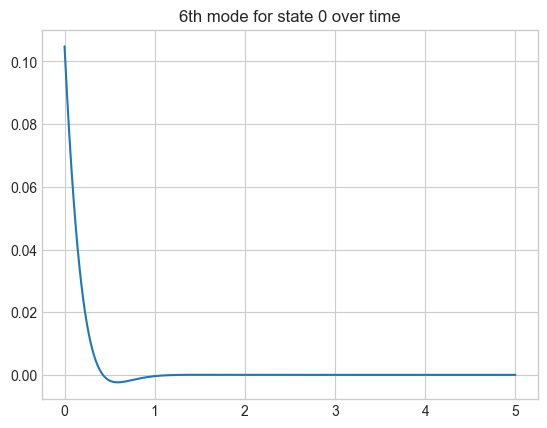

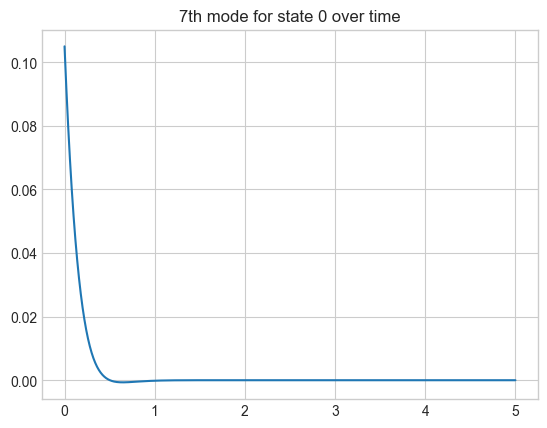

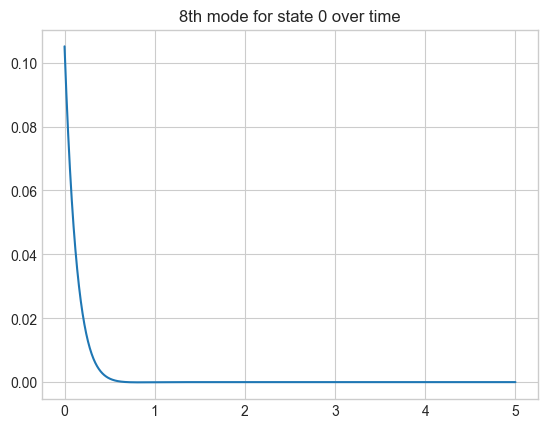

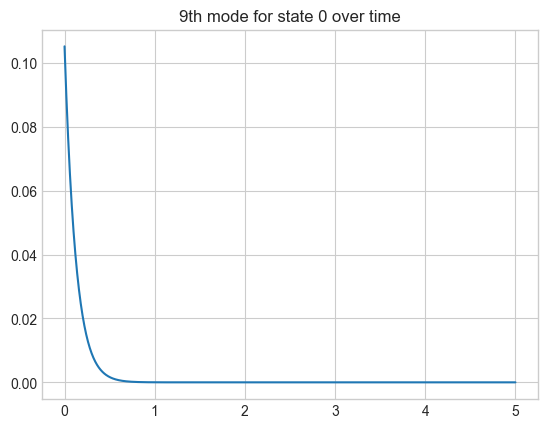

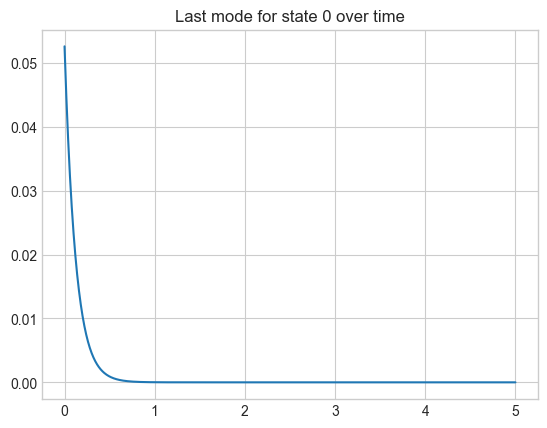

In [11]:
### Explore how probability emerges from eigenvectors

result = np.empty(len(P), dtype=np.complex128)

# Get product of left hand and right hand eigenvectors Q_1 and P_1 that appears in formula for probability density
for i in range(len(P)):
    result[i] = (Q[-2][0] * P[-2][i])

# Plot
colors = np.linspace(0,len(Q),len(Q))
plt.scatter(result.real, result.imag, c=colors ,cmap='viridis')
plt.colorbar()
plt.show()

# Repeat for eigenvector that belong to complex conjugated eingenvalue

result_2 = np.empty(len(P), dtype=np.complex128)

# Get product of left hand and right hand eigenvectors Q_1 and P_1 that appears in formula for probability density
for i in range(len(P)):
    result_2[i] = (Q[-3][0] * P[-3][i])

# Plot
colors = np.linspace(0,len(Q),len(Q))
plt.scatter(result_2.real, result_2.imag, c=colors ,cmap='viridis')
plt.colorbar()
plt.show()

# Plot sum of products

combi = result + result_2 # this quantitiy turns out to be real valued

x = np.arange(len(P))

plt.scatter(x, combi, c=colors ,cmap='viridis')
plt.colorbar()
plt.show()

# Now we visualize the individual modes
# We start with the first state

t = np.linspace(0,5,1000)

first_product = np.empty(len(P), dtype=np.complex128)
first_product =[P[-1][i] for i in range(len(P))]
first_mode = [first_product[0] for i in t]
plt.plot(t, first_mode)
plt.title(f'Stationary mode for state 0 over time')
plt.show()

for k in range(2,19,2):
    k_th_product = np.empty(len(P), dtype=np.complex128)
    k_p1_th_product = np.empty(len(P), dtype=np.complex128)

    k_th_product =[(Q[-k][0] * P[-k][i]) for i in range(len(P))]
    k_p1_th_product = [(Q[-k+-1][0] * P[-k-1][i]) for i in range(len(P))]
    k_th_mode = [k_th_product[0] * np.exp(i*eigenvals[-k]) + k_p1_th_product[0] * np.exp(i*eigenvals[-k-1]) for i in t]

    plt.plot(t, k_th_mode)
    plt.title(f'{int(k/2)}th mode for state 0 over time')
    plt.show()

last_product = np.empty(len(P), dtype=np.complex128)
last_product =[(Q[0][0] * P[0][i]) for i in range(len(P))]
last_mode = [last_product[0] * np.exp(i*eigenvals[0]) for i in t]
plt.plot(t, last_mode)
plt.title(f'Last mode for state 0 over time')
plt.show()

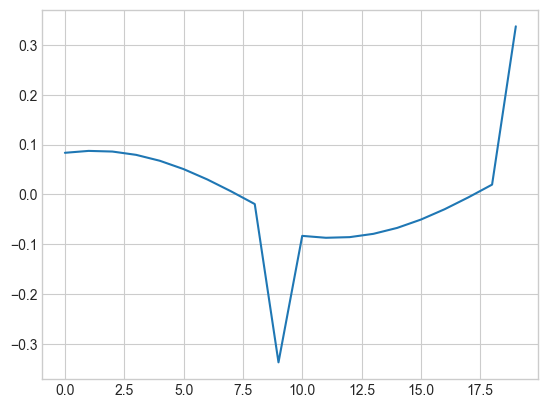

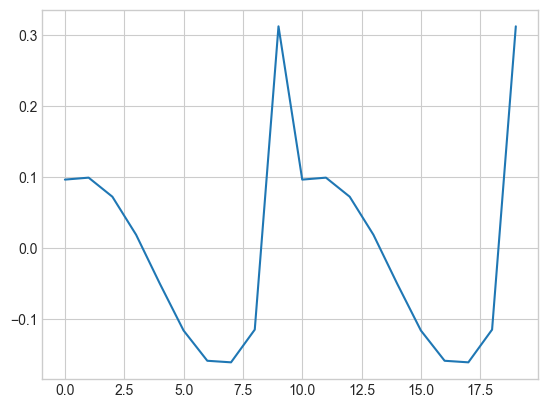

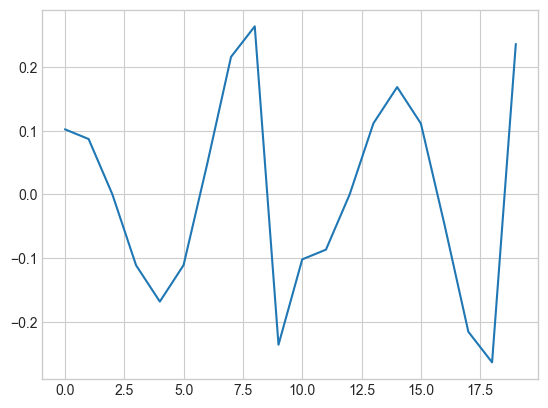

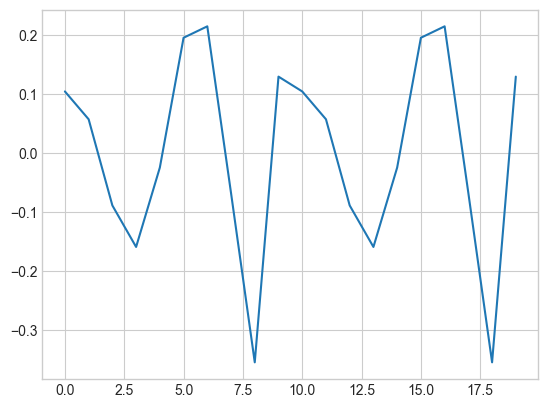

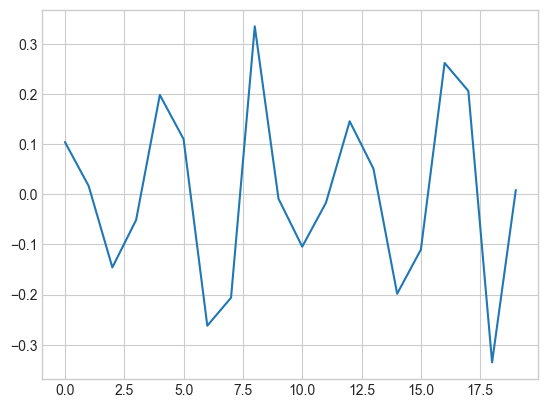

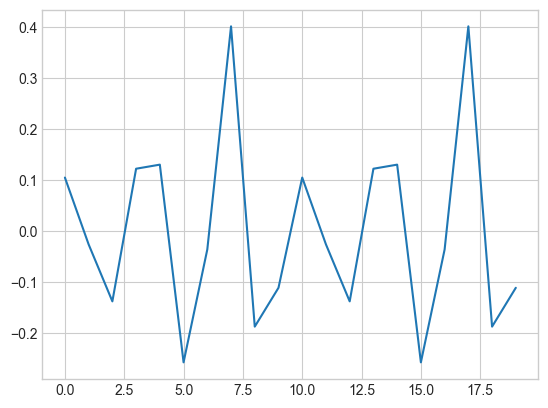

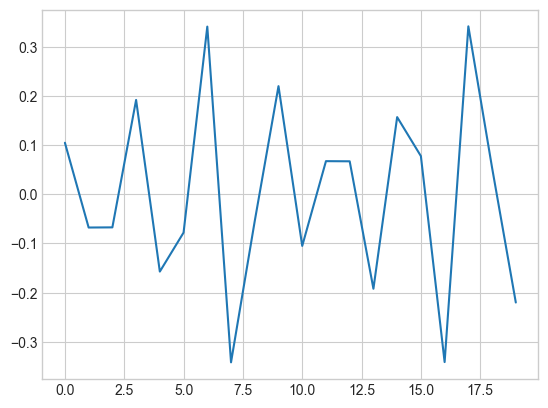

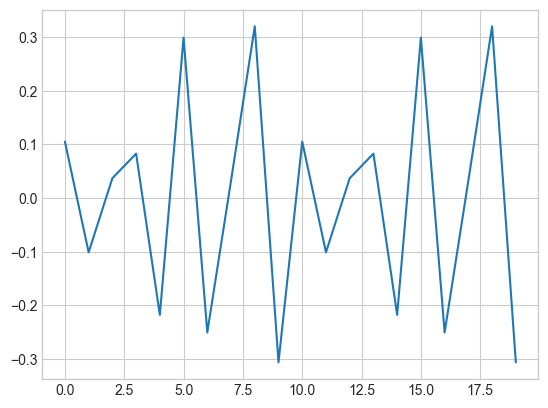

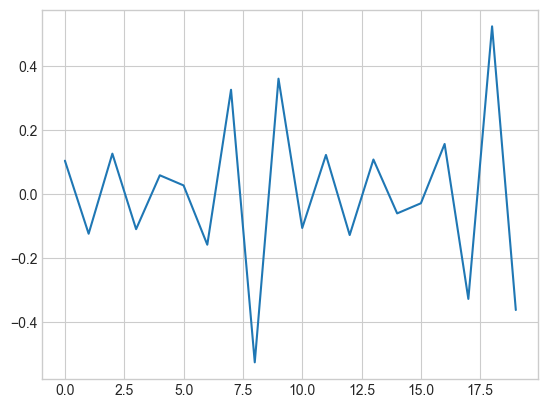

In [12]:
initial_state = 0
time_of_observation = 0

for i in range(2,19,2):
    prob_flow_vec = np.empty(len(P), dtype=np.complex128)
    basis_v_1 = np.empty(len(P), dtype=np.complex128)
    basis_v_2 = np.empty(len(P), dtype=np.complex128)

    basis_v_1 = Q[-i][initial_state] * P[-i]
    basis_v_2 = Q[-i-1][initial_state] * P[-i-1]

    prob_flow_vec = np.exp(eigenvals[-i]*time_of_observation) * basis_v_1 + np.exp(eigenvals[-i-1]*time_of_observation) * basis_v_2

    # Plot
    colors = np.linspace(0,len(Q),len(Q))
    x = np.arange(len(P))

    plt.plot(x,prob_flow_vec)
    #plt.scatter(x, prob_flow_vec, c=colors ,cmap='viridis')
    #plt.colorbar()
    plt.show()

In [13]:
def arccot(x):
    return np.pi/2 - np.arctan(x)

def ellipse(k, a_vec, b_vec, omega, phi_0):
    return np.cos(omega*k + phi_0) * a_vec + np.sin(omega*k + phi_0) * b_vec

def get_state_vec(state_number):
    #define pure state vector
    state_vec = np.zeros(len(Q))
    state_vec[state_number] = 1
    #translate state vec into plane of ellipse
    state_vec = state_vec - P[-1]
    return state_vec

[-0.15204787 -0.15901881 -0.15665055 -0.1445443  -0.12287481 -0.09241307
 -0.05451381 -0.01106644  0.03558957  0.61494942  0.15204787  0.15901881
  0.15665055  0.1445443   0.12287481  0.09241307  0.05451381  0.01106644
 -0.03558957 -0.61494942]
[-0.00685161  0.00202294  0.01129038  0.02040567  0.02880132  0.03592091
  0.04125381  0.04436913  0.04494681  0.06678428  0.00685161 -0.00202294
 -0.01129038 -0.02040567 -0.02880132 -0.03592091 -0.04125381 -0.04436913
 -0.04494681 -0.06678428]
0.05814416846782637
0.9742688365184765
8.378044283646267


/var/folders/39/p2xs9v7547vfxg9djk82zf3c0000gn/T/ipykernel_49970/892452160.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  projection[0] = (vec @ a1_vec) * (np.sqrt(a1_vec@a1_vec))
/var/folders/39/p2xs9v7547vfxg9djk82zf3c0000gn/T/ipykernel_49970/892452160.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
  projection[1] = (vec @ x_vec) * (np.sqrt(x_vec@x_vec))


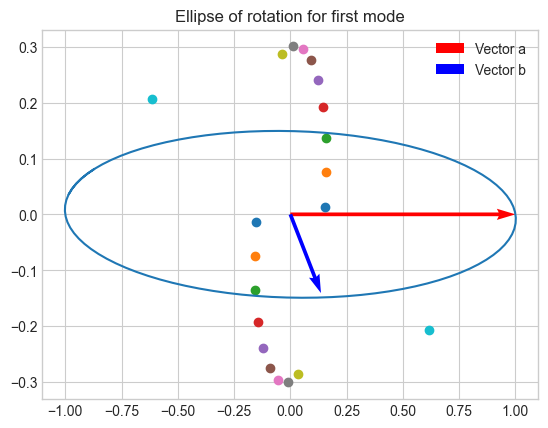

In [14]:
### Visualize the ellipses of the modes of oscillation:

#initial state
initial_state = 1
#these are the conjugated half parameters
a1_vec = P[-2].real
a1_vec = 1/(np.sqrt(a1_vec@a1_vec)) * a1_vec
b1_vec = P[-2].imag
#circular frequency
omega_1 = eigenvals[-2].imag
#phase
phi_0 = np.arctan2(Q[-2][initial_state].imag, Q[-2][initial_state].real)

print(a1_vec)
print(b1_vec)
print(a1_vec@b1_vec)
print((a1_vec@a1_vec - b1_vec@b1_vec))
print((a1_vec@a1_vec - b1_vec@b1_vec)/(2*a1_vec@b1_vec))

#get the extremal points of the ellipse

#determine parameter k_0 for extremal point
k_0 = 0.5 * arccot((a1_vec@a1_vec - b1_vec@b1_vec)/(2*a1_vec@b1_vec))

#get extremal point
major_axis = ellipse((k_0 - phi_0)/(omega_1), a1_vec, b1_vec, omega_1, phi_0)
minor_axis = ellipse((k_0 - phi_0)/(omega_1) + np.pi/2, a1_vec, b1_vec, omega_1, phi_0)


# get vector in ellipse plane which is orthogonal to a
sum1 = 0
sum2 = 0
for i in range(len(a1_vec)):
    sum1 += a1_vec[i]**2
    sum2 += a1_vec[i] * b1_vec[i]


x1 = 1
x2 = -sum1/sum2 * x1

x_vec = x1 * a1_vec + x2 * b1_vec

#Normalize a1_vec and x_vec which we are gonna use as basis vectors for our plane to project onto
x_vec = 1/(np.sqrt(x_vec@x_vec)) * x_vec


def get_2d_projection(proba_path):
    two_d_projection = []

    for vec in proba_path:
        projection = np.zeros(2)
        projection[0] = (vec @ a1_vec) * (np.sqrt(a1_vec@a1_vec))
        projection[1] = (vec @ x_vec) * (np.sqrt(x_vec@x_vec))
        two_d_projection.append(projection)

    return two_d_projection

def get_x_coords(path):
    x_coords = np.array([vec[0] for vec in path])
    return x_coords

def get_y_coords(path):
    y_coords = np.array([vec[1] for vec in path])
    return y_coords

ellipse_points = [ellipse(k, a1_vec, b1_vec, omega_1, phi_0) for k in np.linspace(0,2*np.pi, 100)]
ellipse_points_2d = get_2d_projection(ellipse_points)

plt.plot(get_x_coords(ellipse_points_2d), get_y_coords(ellipse_points_2d))
plt.quiver(0,0,get_2d_projection([a1_vec])[0][0], get_2d_projection([a1_vec])[0][1],scale_units='xy', scale=1, color='red', label='Vector a')
plt.quiver(0,0,get_2d_projection([b1_vec])[0][0], get_2d_projection([b1_vec])[0][1],scale_units='xy', scale=1, color='blue', label='Vector b')
#plt.quiver(0,0,get_2d_projection([major_axis])[0][0], get_2d_projection([major_axis])[0][1],scale_units='xy', scale=1, color='green', label='major axis')
#plt.quiver(0,0,get_2d_projection([minor_axis])[0][0], get_2d_projection([minor_axis])[0][1],scale_units='xy', scale=1, color='purple', label='minor axis')
for i in range(len(Q)):
    plt.scatter(get_2d_projection([get_state_vec(i)])[0][0], get_2d_projection([get_state_vec(i)])[0][1])
plt.legend(loc = 'upper right')
plt.title(f'Ellipse of rotation for first mode')
plt.show()

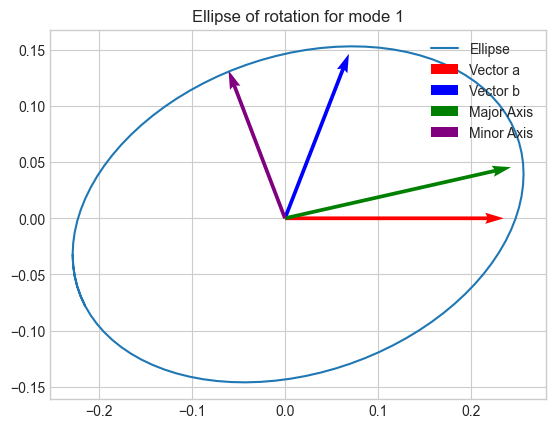

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def arccot(x):
    return np.pi/2 - np.arctan(x)

def ellipse(k, a_vec, b_vec, omega, phi_0):
    return np.cos(omega*k + phi_0) * a_vec + np.sin(omega*k + phi_0) * b_vec

def get_state_vec(state_number):
    # This function seems to be defined elsewhere, assuming it works
    # We will need the original vectors to center the data
    pass

# --- Corrected code starts here ---

# Store the original vectors without modification
a1_vec_orig = P[-2].real
b1_vec_orig = P[-2].imag
omega_1 = eigenvals[-2].imag
phi_0 = np.arctan2(Q[-2][initial_state].imag, Q[-2][initial_state].real)

# Get the extremal points of the ellipse
k_0 = 0.5 * arccot((a1_vec_orig@a1_vec_orig - b1_vec_orig@b1_vec_orig) / (2*a1_vec_orig@b1_vec_orig))
major_axis = ellipse((k_0 - phi_0)/omega_1, a1_vec_orig, b1_vec_orig, omega_1, phi_0)
minor_axis = ellipse((k_0 - phi_0)/omega_1 + np.pi/2, a1_vec_orig, b1_vec_orig, omega_1, phi_0)

# Create a robust, orthonormal basis using Gram-Schmidt
v1_basis = a1_vec_orig / np.linalg.norm(a1_vec_orig)
v2_raw = b1_vec_orig - np.dot(b1_vec_orig, v1_basis) * v1_basis
v2_basis = v2_raw / np.linalg.norm(v2_raw)

def get_2d_projection(proba_path, center_point=None):
    two_d_projection = []
    
    # Center the data if a center point is provided
    if center_point is not None:
        centered_path = [vec - center_point for vec in proba_path]
    else:
        centered_path = proba_path
    
    for vec in centered_path:
        projection = np.zeros(2)
        projection[0] = np.dot(vec, v1_basis)
        projection[1] = np.dot(vec, v2_basis)
        two_d_projection.append(projection)
        
    return two_d_projection

# --- Plotting section ---

# Get points on the ellipse
num_points = 100
t_vals = np.linspace(0, 2*np.pi, num_points)
ellipse_points = [ellipse(k, a1_vec_orig, b1_vec_orig, omega_1, phi_0) for k in t_vals]

# Center the vectors before projection for visualization
center_point = np.mean(ellipse_points, axis=0)
ellipse_points_2d = get_2d_projection(ellipse_points, center_point)

plt.plot([p[0] for p in ellipse_points_2d], [p[1] for p in ellipse_points_2d], label='Ellipse')

# Project the original vectors
a1_proj = get_2d_projection([a1_vec_orig], np.zeros_like(a1_vec_orig))[0]
b1_proj = get_2d_projection([b1_vec_orig], np.zeros_like(b1_vec_orig))[0]
major_proj = get_2d_projection([major_axis], np.zeros_like(major_axis))[0]
minor_proj = get_2d_projection([minor_axis], np.zeros_like(minor_axis))[0]

plt.quiver(0, 0, a1_proj[0], a1_proj[1], scale_units='xy', scale=1, color='red', label='Vector a')
plt.quiver(0, 0, b1_proj[0], b1_proj[1], scale_units='xy', scale=1, color='blue', label='Vector b')
plt.quiver(0, 0, major_proj[0], major_proj[1], scale_units='xy', scale=1, color='green', label='Major Axis')
plt.quiver(0, 0, minor_proj[0], minor_proj[1], scale_units='xy', scale=1, color='purple', label='Minor Axis')

plt.legend(loc='upper right')
plt.title(f'Ellipse of rotation for mode 1')
plt.show()

Estimated chi(omega): (1.0131250540717884-0.07700293316130379j)
Theoretical chi(omega): (0.9900990099009901+0.09900990099009901j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     1.013125    theo =     0.990099
  imag        est =    -0.077003    theo =     0.099010
  magnitude   est =     1.016047    theo =     0.995037
  phase_deg   est =    -4.346430    theo =     5.710593


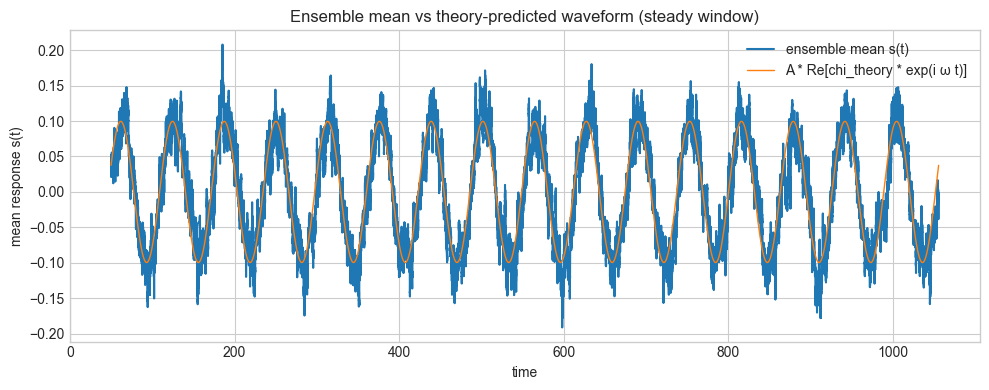

Estimated chi(omega): (0.8181536210962738-0.44710037864267477j)
Theoretical chi(omega): (0.8+0.4j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.818154    theo =     0.800000
  imag        est =    -0.447100    theo =     0.400000
  magnitude   est =     0.932349    theo =     0.894427
  phase_deg   est =   -28.655495    theo =    26.565051


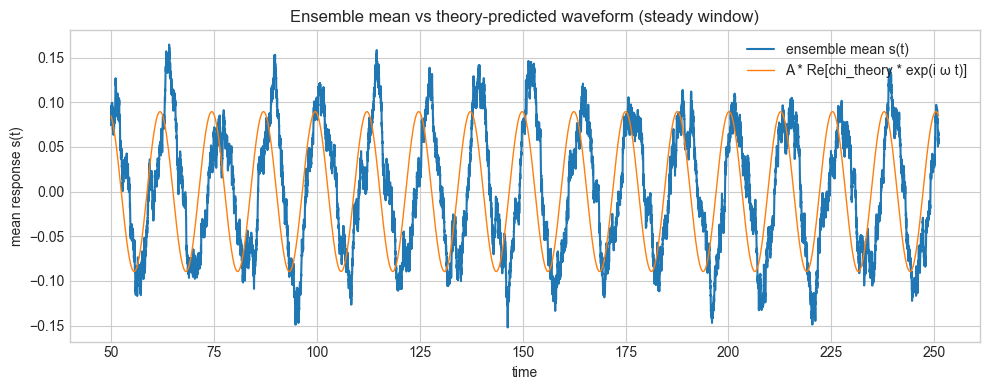

Estimated chi(omega): (0.5708805113340734-0.5015780912983965j)
Theoretical chi(omega): (0.5+0.5j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.570881    theo =     0.500000
  imag        est =    -0.501578    theo =     0.500000
  magnitude   est =     0.759924    theo =     0.707107
  phase_deg   est =   -41.302680    theo =    45.000000


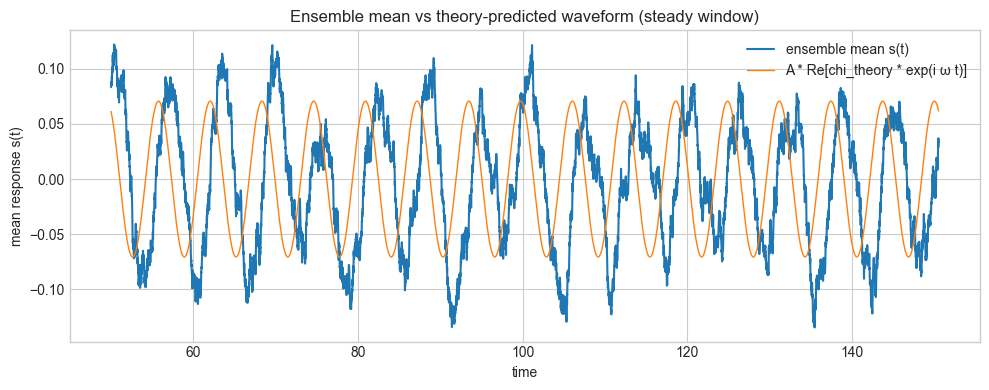

Estimated chi(omega): (0.19333211566095768-0.39655641186407237j)
Theoretical chi(omega): (0.2+0.4j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.193332    theo =     0.200000
  imag        est =    -0.396556    theo =     0.400000
  magnitude   est =     0.441174    theo =     0.447214
  phase_deg   est =   -64.009498    theo =    63.434949


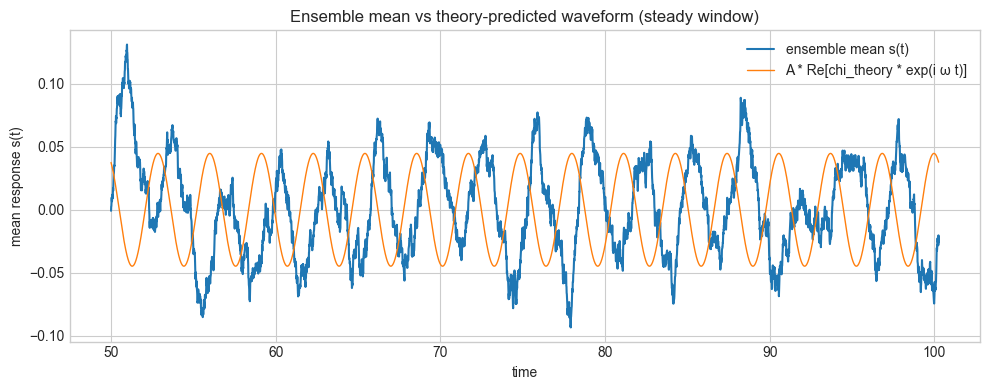

Estimated chi(omega): (0.10962744034654252-0.28926277713295234j)
Theoretical chi(omega): (0.09999999999999999+0.3j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.109627    theo =     0.100000
  imag        est =    -0.289263    theo =     0.300000
  magnitude   est =     0.309340    theo =     0.316228
  phase_deg   est =   -69.243838    theo =    71.565051


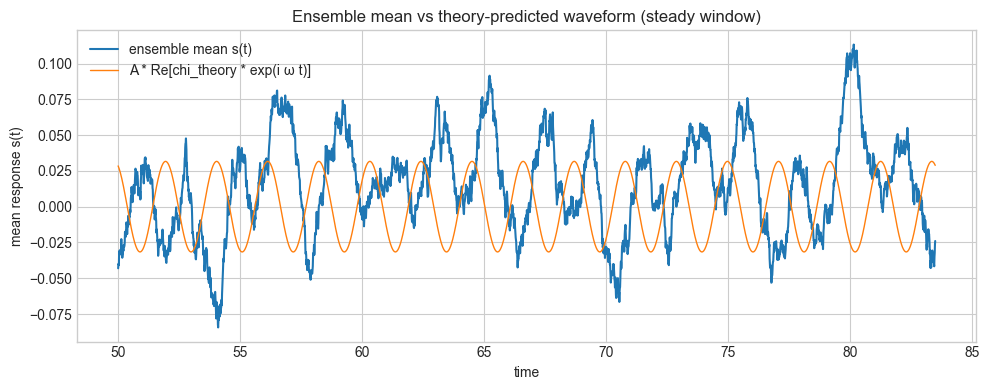

Estimated chi(omega): (0.11083079493271003-0.2813144944865005j)
Theoretical chi(omega): (0.058823529411764705+0.23529411764705882j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.110831    theo =     0.058824
  imag        est =    -0.281314    theo =     0.235294
  magnitude   est =     0.302360    theo =     0.242536
  phase_deg   est =   -68.496814    theo =    75.963757


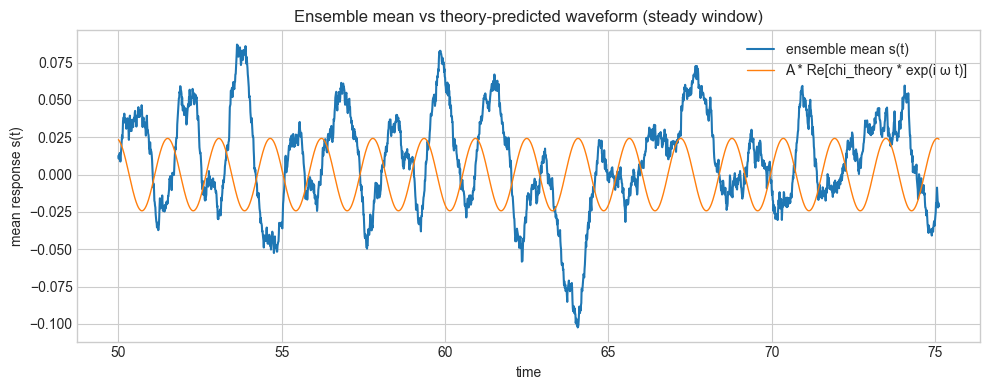

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


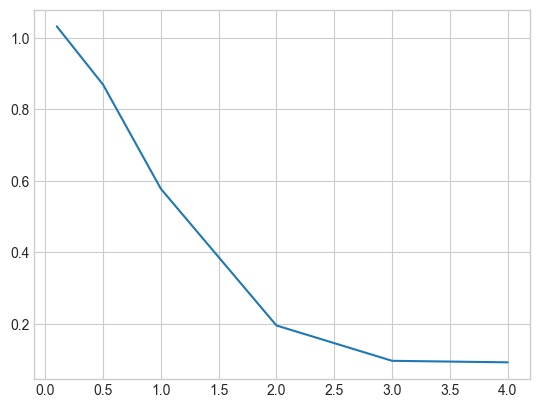

In [16]:
# Python code to simulate an Ornstein–Uhlenbeck process with a small cosine forcing,
# compute an estimator for the susceptibility chi(omega) from the ensemble-averaged
# response, and compare with the theoretical chi(omega)=1/(gamma - i*omega).
#
# This code:
#  - simulates M realizations using vectorized Euler–Maruyama
#  - computes the ensemble mean s(t)
#  - estimates chi with \hat\chi = 2/(A T) \int s(t) e^{-i \omega t} dt over a steady window
#  - compares estimate to theory and plots the mean time series vs theory-predicted waveform
#  - prints numerical comparison and shows a small table of results
#
# You can change parameters (gamma, omega, A, M, dt, etc.) to explore behavior.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(1)

# Parameters
gamma = 1.0        # relaxation rate
D = 0.5            # diffusion coefficient (noise strength)
A = 0.1            # amplitude of cosine forcing (small for linear regime)
omega_list = [0.1,0.5,1,2,3,4]        # driving frequency
dt = 0.01
chi_hat_list = []
for omega in omega_list:
    period = 2 * np.pi / omega

    # Choose transient and steady window (make the window an integer number of periods)
    n_periods_window = 16
    T_window = n_periods_window * period
    t_transient = 50.0
    t_total = t_transient + T_window

    # Time grid
    N = int(np.round(t_total / dt))
    t = np.arange(N) * dt

    # Ensemble size (vectorized simulation)
    M = 800

    # Prepare arrays
    x = np.zeros(M)            # state for each realization
    s_mean = np.zeros(N)       # will accumulate ensemble mean over time

    sqrt_2Ddt = np.sqrt(2 * D * dt)

    # Simulate (vectorized in ensemble dimension)
    for n in range(N):
        forcing = A * np.cos(omega * t[n])
        # Euler-Maruyama step for all M realizations at once
        x += (-gamma * x + forcing) * dt + sqrt_2Ddt * np.random.randn(M)
        s_mean[n] = x.mean()

    # Select steady window (integer number of periods)
    idx0 = int(np.round(t_transient / dt))
    idx1 = idx0 + int(np.round(T_window / dt))
    t_win = t[idx0:idx1]
    s_win = s_mean[idx0:idx1]
    T_actual = (len(t_win)) * dt

    # Estimator for chi(omega)
    hat_chi = (2.0 / (A * T_actual)) * np.sum(s_win * np.exp(-1j * omega * t_win)) * dt

    # Theoretical susceptibility for OU with additive forcing:
    chi_theory = 1.0 / (gamma - 1j * omega)

    # Reconstructed waveform from theory for plotting
    s_theory_wave = A * np.real(chi_theory * np.exp(1j * omega * t_win))

    # Print numerical comparison
    def complex_info(z):
        return {
            "real": np.real(z),
            "imag": np.imag(z),
            "magnitude": np.abs(z),
            "phase_deg": np.angle(z, deg=True)
        }

    est_info = complex_info(hat_chi)
    theo_info = complex_info(chi_theory)

    print("Estimated chi(omega):", hat_chi)
    print("Theoretical chi(omega):", chi_theory)
    print("\nEstimated vs Theoretical (real, imag, |chi|, phase [deg]):")
    for key in ["real", "imag", "magnitude", "phase_deg"]:
        print(f"  {key:10s}  est = {est_info[key]:12.6f}    theo = {theo_info[key]:12.6f}")


    # Plot mean time series in the window and the theory-predicted waveform
    plt.figure(figsize=(10, 4))
    plt.plot(t_win, s_win, label="ensemble mean s(t)")
    plt.plot(t_win, s_theory_wave, label="A * Re[chi_theory * exp(i ω t)]", linewidth=1)
    plt.xlabel("time")
    plt.ylabel("mean response s(t)")
    plt.title("Ensemble mean vs theory-predicted waveform (steady window)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Additional numeric output for convenience
    result_table = pd.DataFrame({
        "name": ["estimated_chi", "theoretical_chi"],
        "complex": [str(hat_chi), str(chi_theory)],
        "real": [est_info["real"], theo_info["real"]],
        "imag": [est_info["imag"], theo_info["imag"]],
        "abs": [est_info["magnitude"], theo_info["magnitude"]],
        "phase_deg": [est_info["phase_deg"], theo_info["phase_deg"]]
    })

    # Show the returned estimate explicitly for copy-paste
    chi_hat_list.append(hat_chi)

plt.plot(omega_list, [chi_hat * np.conjugate(chi_hat) for chi_hat in chi_hat_list])
plt.show()


Parameters: a = 1.0  b = 0.8  lambda = 1.8  A = 0.1  omega = 1.0

Estimated hat_chi(omega): (0.36556465002560695-0.17609063910967174j)
Theoretical chi(omega):     (0.37735849056603776+0.20964360587002098j)

Estimated vs Theoretical (real, imag, |chi|, phase [deg]):
  real        est =     0.365565    theo =     0.377358
  imag        est =    -0.176091    theo =     0.209644
  magnitude   est =     0.405765    theo =     0.431683
  phase_deg   est =   -25.719881    theo =    29.054604


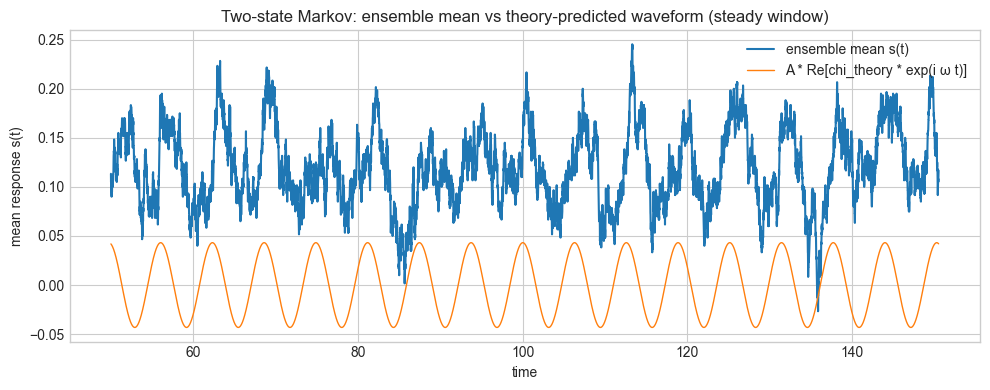

(0.36556465002560695-0.17609063910967174j)

In [17]:
# Two-state Markov jump process simulation with a weak cosine perturbation.
# We simulate M independent realizations with a time-dependent jump probability
# (small dt approximation), compute the ensemble mean s(t) of the observable
# x in {-1, +1} (state 0 -> -1, state 1 -> +1), and estimate the susceptibility
# via \hat\chi = 2/(A*T) \int s(t) e^{-i omega t} dt over a steady window.
#
# We also compute the theoretical linear-response susceptibility for the
# chosen way of coupling the perturbation to the rates:
#   r01(t) = a * exp(+h(t)/2),  r10(t) = b * exp(-h(t)/2),  h(t)=A*cos(omega t)
# Linearizing gives:  chi_theory(omega) = (2 a b / (a+b)) / ( (a+b) - i omega )
#
# The code shows numeric comparison and a plot.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

# --- parameters ---
a = 1.0            # base rate 0 -> 1
b = 0.8            # base rate 1 -> 0
lam = a + b        # relaxation rate
A = 0.1            # amplitude of "bias" h(t) entering rates as exp(±h/2)
omega = 1.0        # driving frequency
dt = 0.01
period = 2 * np.pi / omega

# choose transient and steady window
n_periods_window = 16
T_window = n_periods_window * period
t_transient = 50.0
t_total = t_transient + T_window

# time grid
N = int(np.round(t_total / dt))
t = np.arange(N) * dt

# ensemble size (vectorized simulation)
M = 1200

# prepare state array (0 or 1) and storage for ensemble mean of x in {-1,+1}
state = np.zeros(M, dtype=np.int8)  # start all in state 0 (you can randomize)
s_mean = np.zeros(N, dtype=float)

# vectorized simulation loop: at each dt, compute rates and jump probabilities
for n in range(N):
    h = A * np.cos(omega * t[n])
    r01 = a * np.exp(+0.5 * h)
    r10 = b * np.exp(-0.5 * h)
    # jump probabilities in dt (valid for small dt)
    p01 = r01 * dt
    p10 = r10 * dt
    # for state==0 decide jumps 0->1 where uniform < p01
    u = np.random.rand(M)
    jump01 = (state == 0) & (u < p01)
    # for state==1 decide jumps 1->0 where uniform < p10
    u2 = np.random.rand(M)
    jump10 = (state == 1) & (u2 < p10)
    # update states
    state[jump01] = 1
    state[jump10] = 0
    # observable x in {-1,+1}
    xvals = np.where(state == 1, +1.0, -1.0)
    s_mean[n] = xvals.mean()

# steady window indices (integer number of periods)
idx0 = int(np.round(t_transient / dt))
idx1 = idx0 + int(np.round(T_window / dt))
t_win = t[idx0:idx1]
s_win = s_mean[idx0:idx1]
T_actual = len(t_win) * dt

# estimator for chi(omega)
hat_chi = (2.0 / (A * T_actual)) * np.sum(s_win * np.exp(-1j * omega * t_win)) * dt

# theoretical susceptibility derived from linearization (see comments above)
chi_theory = (2.0 * a * b / (a + b)) / ((a + b) - 1j * omega)

# theory-predicted waveform for plotting
s_theory_wave = A * np.real(chi_theory * np.exp(1j * omega * t_win))

# numerical comparison helper
def complex_info(z):
    return {
        "real": np.real(z),
        "imag": np.imag(z),
        "magnitude": np.abs(z),
        "phase_deg": np.angle(z, deg=True)
    }

est_info = complex_info(hat_chi)
theo_info = complex_info(chi_theory)

print("Parameters: a =", a, " b =", b, " lambda =", lam, " A =", A, " omega =", omega)
print("\nEstimated hat_chi(omega):", hat_chi)
print("Theoretical chi(omega):    ", chi_theory)
print("\nEstimated vs Theoretical (real, imag, |chi|, phase [deg]):")
for key in ["real", "imag", "magnitude", "phase_deg"]:
    print(f"  {key:10s}  est = {est_info[key]:12.6f}    theo = {theo_info[key]:12.6f}")

# show a small dataframe
df = pd.DataFrame([
    {"quantity": "real", "estimated": est_info["real"], "theoretical": theo_info["real"]},
    {"quantity": "imag", "estimated": est_info["imag"], "theoretical": theo_info["imag"]},
    {"quantity": "magnitude", "estimated": est_info["magnitude"], "theoretical": theo_info["magnitude"]},
    {"quantity": "phase_deg", "estimated": est_info["phase_deg"], "theoretical": theo_info["phase_deg"]},
])


# plot mean time series and theory waveform in the steady window
plt.figure(figsize=(10, 4))
plt.plot(t_win, s_win, label="ensemble mean s(t)")
plt.plot(t_win, s_theory_wave, label="A * Re[chi_theory * exp(i ω t)]", linewidth=1)
plt.xlabel("time")
plt.ylabel("mean response s(t)")
plt.title("Two-state Markov: ensemble mean vs theory-predicted waveform (steady window)")
plt.legend()
plt.tight_layout()
plt.show()

# return the estimated complex susceptibility so it's visible for copy-paste
hat_chi



In [18]:
import numpy as np
import math
import time
import numba
from numba import njit, prange

# -----------------------
# Numba batch simulator (parallel across realizations)
# -----------------------
@njit(parallel=True)
def two_state_process_numba_batch(number_of_substates, transition_rates, refractory_periods,
                                  total_time, delta_t, n_realizations, out_states):
    """
    Simulate n_realizations into out_states (shape (n_realizations, steps)).
    Each row is one time-series (float32 or float64 depending on out_states dtype).
    Uses inverse-CDF exponential sampling with np.random.random() inside Numba.
    """
    N_A = number_of_substates[0]
    N_B = number_of_substates[1]
    steps = int(math.floor(total_time / delta_t))
    inv_dt = 1.0 / delta_t

    for r in prange(n_realizations):
        pos = 0
        seq = out_states[r]
        current_state = -1.0

        rate_sub_A = (N_A - 1) / refractory_periods[0] if refractory_periods[0] > 0.0 else 0.0
        rate_sub_B = (N_B - 1) / refractory_periods[1] if refractory_periods[1] > 0.0 else 0.0

        # Fill by sampling transitions until we've filled 'steps' values
        while pos < steps:
            # A chain: first N_A - 1 substates (approx refractory)
            if N_A - 1 > 0:
                if rate_sub_A > 0.0:
                    for i_sub in range(N_A - 1):
                        u = np.random.random()
                        # avoid u==0
                        while u <= 0.0:
                            u = np.random.random()
                        t = -math.log(u) / rate_sub_A
                        nsteps = int(math.ceil(t * inv_dt))
                        if nsteps < 1:
                            nsteps = 1
                        end = pos + nsteps
                        if end > steps:
                            end = steps
                        val = current_state
                        for k in range(pos, end):
                            seq[k] = val
                        pos = end
                        current_state += (1.0 / N_A)
                        if pos >= steps:
                            break
                else:
                    # rate 0 -> fill remainder
                    val = current_state
                    for k in range(pos, steps):
                        seq[k] = val
                    pos = steps

            if pos >= steps:
                break

            # last residency in A (exit to B)
            if transition_rates[0] > 0.0:
                u = np.random.random()
                while u <= 0.0:
                    u = np.random.random()
                t_last = -math.log(u) / transition_rates[0]
                nsteps = int(math.ceil(t_last * inv_dt))
                if nsteps < 1:
                    nsteps = 1
                end = pos + nsteps
                if end > steps:
                    end = steps
                val = current_state
                for k in range(pos, end):
                    seq[k] = val
                pos = end
                current_state += (1.0 / N_A)
            else:
                val = current_state
                for k in range(pos, steps):
                    seq[k] = val
                pos = steps

            if pos >= steps:
                break

            # switch to B chain
            current_state = 1.0 / N_B

            # B chain: first N_B - 1 substates
            if N_B - 1 > 0:
                if rate_sub_B > 0.0:
                    for i_sub in range(N_B - 1):
                        u = np.random.random()
                        while u <= 0.0:
                            u = np.random.random()
                        t = -math.log(u) / rate_sub_B
                        nsteps = int(math.ceil(t * inv_dt))
                        if nsteps < 1:
                            nsteps = 1
                        end = pos + nsteps
                        if end > steps:
                            end = steps
                        val = current_state
                        for k in range(pos, end):
                            seq[k] = val
                        pos = end
                        current_state += (1.0 / N_B)
                        if pos >= steps:
                            break
                else:
                    val = current_state
                    for k in range(pos, steps):
                        seq[k] = val
                    pos = steps

            if pos >= steps:
                break

            # last residency in B (exit to A)
            if transition_rates[1] > 0.0:
                u = np.random.random()
                while u <= 0.0:
                    u = np.random.random()
                t_last = -math.log(u) / transition_rates[1]
                nsteps = int(math.ceil(t_last * inv_dt))
                if nsteps < 1:
                    nsteps = 1
                end = pos + nsteps
                if end > steps:
                    end = steps
                val = current_state
                for k in range(pos, end):
                    seq[k] = val
                pos = end
                current_state += (1.0 / N_B)
            else:
                val = current_state
                for k in range(pos, steps):
                    seq[k] = val
                pos = steps

            current_state = -1.0

        # ensure filled
        if pos < steps:
            val = current_state
            for k in range(pos, steps):
                seq[k] = val

    return out_states  # in-place modification, return optional

# -----------------------
# Batch-run wrapper: compute global mean and variance (no full storage)
# -----------------------
def run_mean_and_variance(num_realizations: int,
                          batch_size: int,
                          number_of_substates: tuple,
                          transition_rates: tuple,
                          refractory_periods: tuple,
                          total_time: float,
                          delta_t: float,
                          dtype=np.float32,
                          numba_threads: int = None):
    """
    Simulate `num_realizations` in batches of `batch_size` using the numba batch function.
    Compute final mean and variance time-series across all realizations, without storing them all.
    Returns (mean, variance) as float64 arrays (length = steps).
    """
    import os
    if numba_threads is not None:
        numba.set_num_threads(numba_threads)

    steps = int(math.floor(total_time / delta_t))
    n_batches = (num_realizations + batch_size - 1) // batch_size

    N_total = 0
    mu = np.zeros(steps, dtype=np.float64)
    M2 = np.zeros(steps, dtype=np.float64)

    for b in range(n_batches):
        start_idx = b * batch_size
        remaining = num_realizations - start_idx
        this_batch = batch_size if remaining >= batch_size else remaining

        # allocate batch buffer (float32 to save memory)
        out = np.empty((this_batch, steps), dtype=dtype)

        # call Numba batch simulator (compilation on first call)
        two_state_process_numba_batch(number_of_substates, transition_rates, refractory_periods,
                                      total_time, delta_t, this_batch, out)

        # compute batch mean and M2 (convert to float64 for stability)
        out64 = out.astype(np.float64)
        batch_mean = out64.mean(axis=0)
        diff = out64 - batch_mean[np.newaxis, :]
        batch_M2 = (diff * diff).sum(axis=0)

        # merge batch stats into running stats
        m = this_batch
        n = N_total
        if n == 0:
            mu = batch_mean
            M2 = batch_M2
            N_total = m
        else:
            delta = batch_mean - mu
            mu_new = (n * mu + m * batch_mean) / (n + m)
            M2_new = M2 + batch_M2 + (delta * delta) * (n * m / (n + m))
            mu = mu_new
            M2 = M2_new
            N_total = n + m

        # optional progress
        if (b + 1) % 10 == 0 or (b == n_batches - 1):
            print(f"Processed batch {b+1}/{n_batches}, total realizations: {N_total}")

    var = M2 / (N_total - 1) if N_total > 1 else np.zeros_like(M2)
    return mu, var


In [19]:
number_of_substates = (5, 5)
transition_rates = (0.5, 0.6)
refractory_periods = (0.2, 0.3)
total_time = 1000.0
delta_t = 0.01

n_realizations = 100000
batch_size = 1000                # ~400 MB per batch (float32); adjust if you have more memory
numba_threads = 8                # set to number of physical cores

t0 = time.time()
mean_ts, var_ts = run_mean_and_variance(
    n_realizations, batch_size,
    number_of_substates, transition_rates, refractory_periods,
    total_time, delta_t, dtype=np.float32, numba_threads=numba_threads)
t1 = time.time()
print("Done. Wallclock:", t1 - t0)


Processed batch 10/100, total realizations: 10000
Processed batch 20/100, total realizations: 20000
Processed batch 30/100, total realizations: 30000
Processed batch 40/100, total realizations: 40000
Processed batch 50/100, total realizations: 50000
Processed batch 60/100, total realizations: 60000
Processed batch 70/100, total realizations: 70000
Processed batch 80/100, total realizations: 80000
Processed batch 90/100, total realizations: 90000
Processed batch 100/100, total realizations: 100000
Done. Wallclock: 53.143397092819214


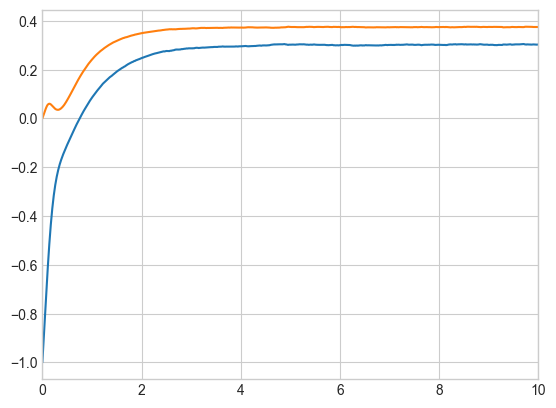

In [20]:
import matplotlib.pyplot as plt

t = np.linspace(0,total_time, int(total_time/delta_t))
plt.plot(t,mean_ts)
plt.plot(t,var_ts)
plt.xlim(0,10)
#plt.ylim(-0.4,0.2)
plt.show()

In [21]:
import numpy as np
from numba import njit, prange

@njit(parallel=True)
def test_bad_seeding(num_trajectories, length):
    """
    Generates a batch of random number sequences in parallel WITHOUT correct seeding.
    """
    output = np.empty((num_trajectories, length))
    
    # Run the outer loop in parallel
    for i in prange(num_trajectories):
        # Each thread will generate a row of random numbers
        for j in range(length):
            output[i, j] = np.random.random()
            
    return output

In [22]:
# Set a seed for reproducibility
np.random.seed(0)

bad_batch = test_bad_seeding(4, 5)

print("--- Batch Generated the WRONG Way ---")
print(bad_batch)

--- Batch Generated the WRONG Way ---
[[0.48740424 0.33229858 0.60338105 0.63273735 0.51131849]
 [0.90650048 0.19631439 0.34536304 0.7748158  0.43696253]
 [0.8033222  0.36343534 0.38356177 0.54490069 0.28630242]
 [0.04352299 0.8947537  0.68894102 0.74630963 0.64182839]]


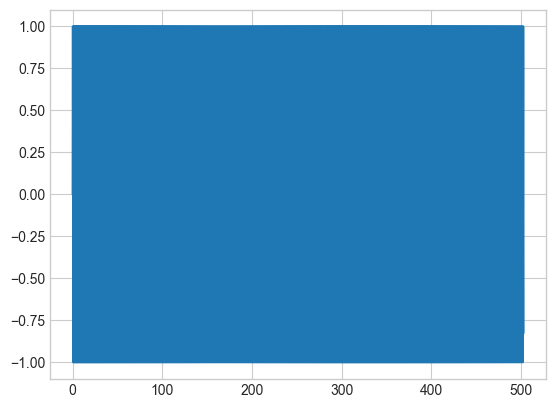

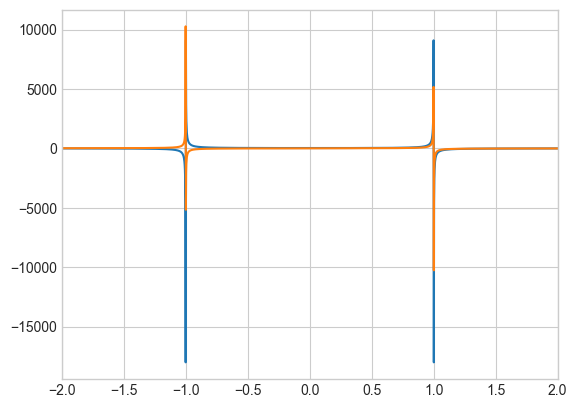

In [23]:
from scipy.fft import fft,ifft,fftfreq,fftshift

t0 = 0
n_periods = 80
T = 2*np.pi*n_periods
delta_t = 0.01
sampling_rate = int(1/delta_t)
n_samples = int(np.floor(T * sampling_rate))

t = np.linspace(t0,T,n_samples)

omega = 2*np.pi
func = np.sin(omega*t)

plt.plot(t,func)
plt.show()

freqs = fftshift(fftfreq(n_samples,delta_t))
spectrum = fftshift(fft(func, n_samples))



plt.plot(freqs,spectrum.real)
plt.plot(freqs,spectrum.imag)
plt.xlim(-2,2)
plt.show()


Average of constant signal: 5.0
Average of oscillating signal: 5.000000000000000
------------------------------
DC Component of constant signal: (5000+0j)
DC Component of oscillating signal: (5000+0j)
------------------------------
Expected DC Component (Average * N): 5000.0

Are the DC components of the two signals practically identical? 👉 True


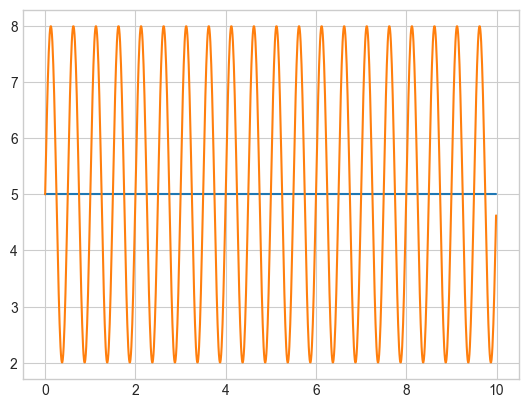

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


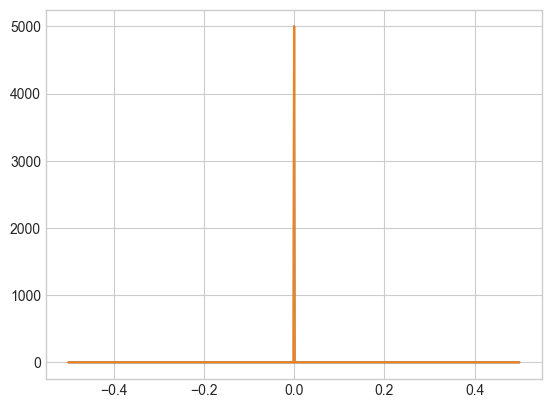

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Signal Parameters ---
N = 1000                  # Number of sample points
SAMPLING_RATE = 100.0     # Sampling rate in Hz
AVERAGE_VALUE = 5.0       # The target average for both signals
OSC_FREQ = 2.0            # Frequency of the oscillating signal in Hz
OSC_AMP = 3.0             # Amplitude of the oscillation

# Create a time axis
# Duration of the signal is N / SAMPLING_RATE
time = np.linspace(0.0, N / SAMPLING_RATE, N, endpoint=False)

# --- 2. Create the Signals ---

# a) Constant signal with the target average
constant_signal = np.full(N, AVERAGE_VALUE)

# b) Oscillating signal (sine wave) with the same average
oscillating_signal = AVERAGE_VALUE + OSC_AMP * np.sin(2.0 * np.pi * OSC_FREQ * time)

# --- 3. Verify the Averages ---
# Note: Due to floating-point precision, the sine wave's average might be
# extremely close to the target, but not exactly identical (e.g., 5.000000000000001)
print(f"Average of constant signal: {np.mean(constant_signal)}")
print(f"Average of oscillating signal: {np.mean(oscillating_signal):.15f}")
print("-" * 30)

# --- 4. Take the Fourier Transform ---
# We use np.fft.fft to get the transform. The DC component is the first element.
fft_constant = np.fft.fft(constant_signal)
fft_oscillating = np.fft.fft(oscillating_signal)

# The DC component is at index 0 of the FFT output
dc_component_constant = fft_constant[0]
dc_component_oscillating = fft_oscillating[0]


# --- 5. Compare the DC Components ---
print(f"DC Component of constant signal: {dc_component_constant}")
print(f"DC Component of oscillating signal: {dc_component_oscillating}")
print("-" * 30)

# --- 6. The Core Relationship ---
# Let's verify the rule: DC Component = Average * N
expected_dc = AVERAGE_VALUE * N
print(f"Expected DC Component (Average * N): {expected_dc}")

# Check if the components are equal (using a tolerance for float comparison)
are_equal = np.isclose(dc_component_constant, dc_component_oscillating)
print(f"\nAre the DC components of the two signals practically identical? 👉 {are_equal}")

plt.plot(time,constant_signal)
plt.plot(time,oscillating_signal)
plt.show()
plt.plot(np.fft.fftshift(np.fft.fftfreq(N)), np.fft.fftshift(fft_constant))
plt.plot(np.fft.fftshift(np.fft.fftfreq(N)), np.fft.fftshift(fft_oscillating))
plt.show()

The phase calculated from the fourier transform is: -1.5672881126542113
The actual angular frequency is 0.75 whilst the nearest angular frequency in the linspace is 0.7498953074360241
The actual frequency is 0.1193662073189215 whilst the nearest angular frequency in the linspace is 0.11934954497985976


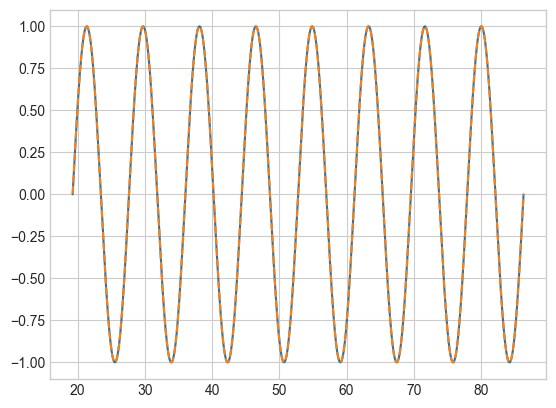

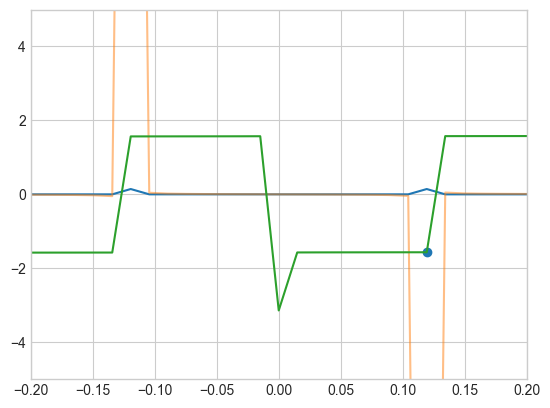

Sample spacing in frequency space: 0.014918693122481841


In [55]:
from scipy.fft import fft,fftfreq,fftshift

#oscillation frequency
omega_os = 0.75
period = 2*np.pi/omega_os

t0 = np.round(2 * period + 3/10 * period, 2)
T = np.round(10*(period) + 3/10 * period, 2)
delta_t = 0.01
n_samples = int((T-t0)/delta_t + 1)

t = np.linspace(t0,T,n_samples)
signal = np.sin(omega_os*t - omega_os*t0)


f = fftshift(fftfreq(n_samples, delta_t))
ft = fftshift(fft(signal, norm='ortho', n=n_samples))
angluar_f = 2*np.pi*f

flag = False
try:
    index = np.argmin(np.abs(omega_os - angluar_f))
except:
    print('No match for this tolerance found.')

phase_shift = np.angle(ft)[index]

print(f'The phase calculated from the fourier transform is: {phase_shift}')
print(f'The actual angular frequency is {omega_os} whilst the nearest angular frequency in the linspace is {angluar_f[index]}')
print(f'The actual frequency is {omega_os/(2*np.pi)} whilst the nearest angular frequency in the linspace is {f[index]}')

plt.plot(t,signal)
plt.plot(t, np.cos(omega_os*t + phase_shift - t0*omega_os), linestyle ='dashed')
plt.show()

plt.plot(f,ft.real)
plt.plot(f,ft.imag, alpha=0.5)
plt.plot(f,np.angle(ft))
plt.scatter(f[index], np.angle(ft)[index])
plt.ylim(-5,5)
plt.xlim(-0.2,0.2)
plt.show()



print(f'Sample spacing in frequency space: {f[3] - f[2]}')